# Manuscript figures

In [1]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import scipy.cluster.hierarchy as sch
import biotite.structure.io.pdb as pdb
import biotite.structure as struc
import numpy as np
import sys
sys.path.append("../bin")
from sequence import get_sequence
from sequence import find_sortase
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches 
import matplotlib.gridspec as gridspec
from constants import NON_ISOPEP_DOMAINS as non_isopep
from constants import ISOPEP_DOMAINS as isopep
from constants import PREV_KNOWN_ISOPEP as prev_known_isopep
import warnings
from dotenv import load_dotenv
from Bio import BiopythonParserWarning
load_dotenv("../.env")
warnings.simplefilter('ignore', BiopythonParserWarning)
pd.set_option('display.max_columns', None)


In [2]:
AFDB_JESS_SCAN_TABLE = os.getenv("AFDB_JESS_SCAN_TABLE")
AFDB_HMM_SCAN_TABLE = os.getenv("AFDB_HMM_SCAN_TABLE")
PDB_BIOCHEM = os.getenv("PDB_BIOCHEM")
AF_DATA_TABLE = os.getenv("AF2_TEMPLATES_BIOCHEM")
POSITIVE_CONTROL_IDENTITIES = os.getenv("POSITIVE_CONTROL_IDENTITIES")
POSITIVE_CONTROL = os.getenv("POSITIVE_CONTROL")
AFDB_DOMAINS = os.getenv("AFDB_DOMAINS")
HMM_DOMAINS = os.getenv("HMM_DOMAINS")
ADH_TABLE = os.getenv("ADH_TABLE")
STALK_TABLE = os.getenv("STALK_TABLE")
AFDB_SCAN_SEQUENCES = os.getenv("AFDB_SCAN_SEQUENCES")
ARCHAEA_RANDOM_SEQUENCES = os.getenv("ARCHAEA_RANDOM_SEQUENCES")
BACTERIA_RANDOM_SEQUENCES = os.getenv("BACTERIA_RANDOM_SEQUENCES")
FIGURES = "../figures"
INPUT_FIGURES = "../data/input_figures"

In [3]:
# Biophysical data table
dt_df = pd.read_csv(PDB_BIOCHEM)
dt_df["mean_rASA"] = dt_df["rASA"].apply(lambda x: np.mean(eval(x)))
af_df = pd.read_csv(AF_DATA_TABLE)

# Get isopep sequence (between bonded residues)
dt_df["isopep_sequence"] = dt_df.apply(get_sequence, pdb=True, axis=1)
af_df["isopep_sequence"] = af_df.apply(get_sequence, pdb=False, axis=1)

# Stalk and adhesin domains
stalk_df = pd.read_csv(STALK_TABLE).rename(columns={"Pfam ID": "pfamA_acc"})
adh_df = pd.read_csv(ADH_TABLE).rename(columns={"Pfam ID": "pfamA_acc"})

# Random bacteria and archaea sequences
random_seqs_df = pd.concat([pd.read_csv(ARCHAEA_RANDOM_SEQUENCES), 
                pd.read_csv(BACTERIA_RANDOM_SEQUENCES)])
random_seqs_df["kingdom"] = random_seqs_df["taxonomy"].apply(lambda x: x.split(";")[0].replace(".", ""))

# Isopeptor-based AFDB scan
str_df = pd.read_csv(AFDB_JESS_SCAN_TABLE, low_memory=False)

# Whole set of Pfam domains from isopeptor-detected proteins
strd_df = pd.read_csv(AFDB_DOMAINS)

# Sequences of isopeptor-detected proteins
seq_df = pd.read_csv(AFDB_SCAN_SEQUENCES)
# Add missing info
seq_df = pd.merge(seq_df, str_df[["uniprot_acc", "kingdom"]])
seq_df["len"] = seq_df["sequence"].apply(len) 

# Find sortase motifs
ib_proteins = str_df[(str_df["probability"]>.65)&(str_df["kingdom"]=="Bacteria")&(~str_df["pfamA_id"].isin(non_isopep))]["uniprot_acc"].unique()
sub_df = seq_df[(seq_df["uniprot_acc"].isin(ib_proteins))].copy()
sub_df["Sortase motif"] = sub_df["sequence"].apply(find_sortase)

# Add to domains dataset
strd_df = pd.concat([strd_df, sub_df[(sub_df["Sortase motif"])][["uniprot_acc"]]\
        .assign(pfamA_id="Sortase motif")\
        .assign(pfamA_acc="PFXXXXX")[["uniprot_acc", "pfamA_acc", "pfamA_id"]]])

In [4]:
# plot params
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.weight'] = 'normal'
mpl.rcParams['axes.labelsize'] = 20
mpl.rcParams['axes.labelweight'] = 'normal'
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['axes.titleweight'] = 'normal'
# size of letters that specify images
ANNOT_FONT_SIZE = 50

## Figure 2

/tmp/ipykernel_3043949/3371373872.py:43: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  lightgreen_patch = mpatches.Patch(color='lightgreen', alpha=0.3, edgecolor="black", linestyle="--", label="Aromatic cap")
/tmp/ipykernel_3043949/3371373872.py:44: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  ax.legend(handles=ax.get_legend().legendHandles + [lightgreen_patch], loc="lower right")


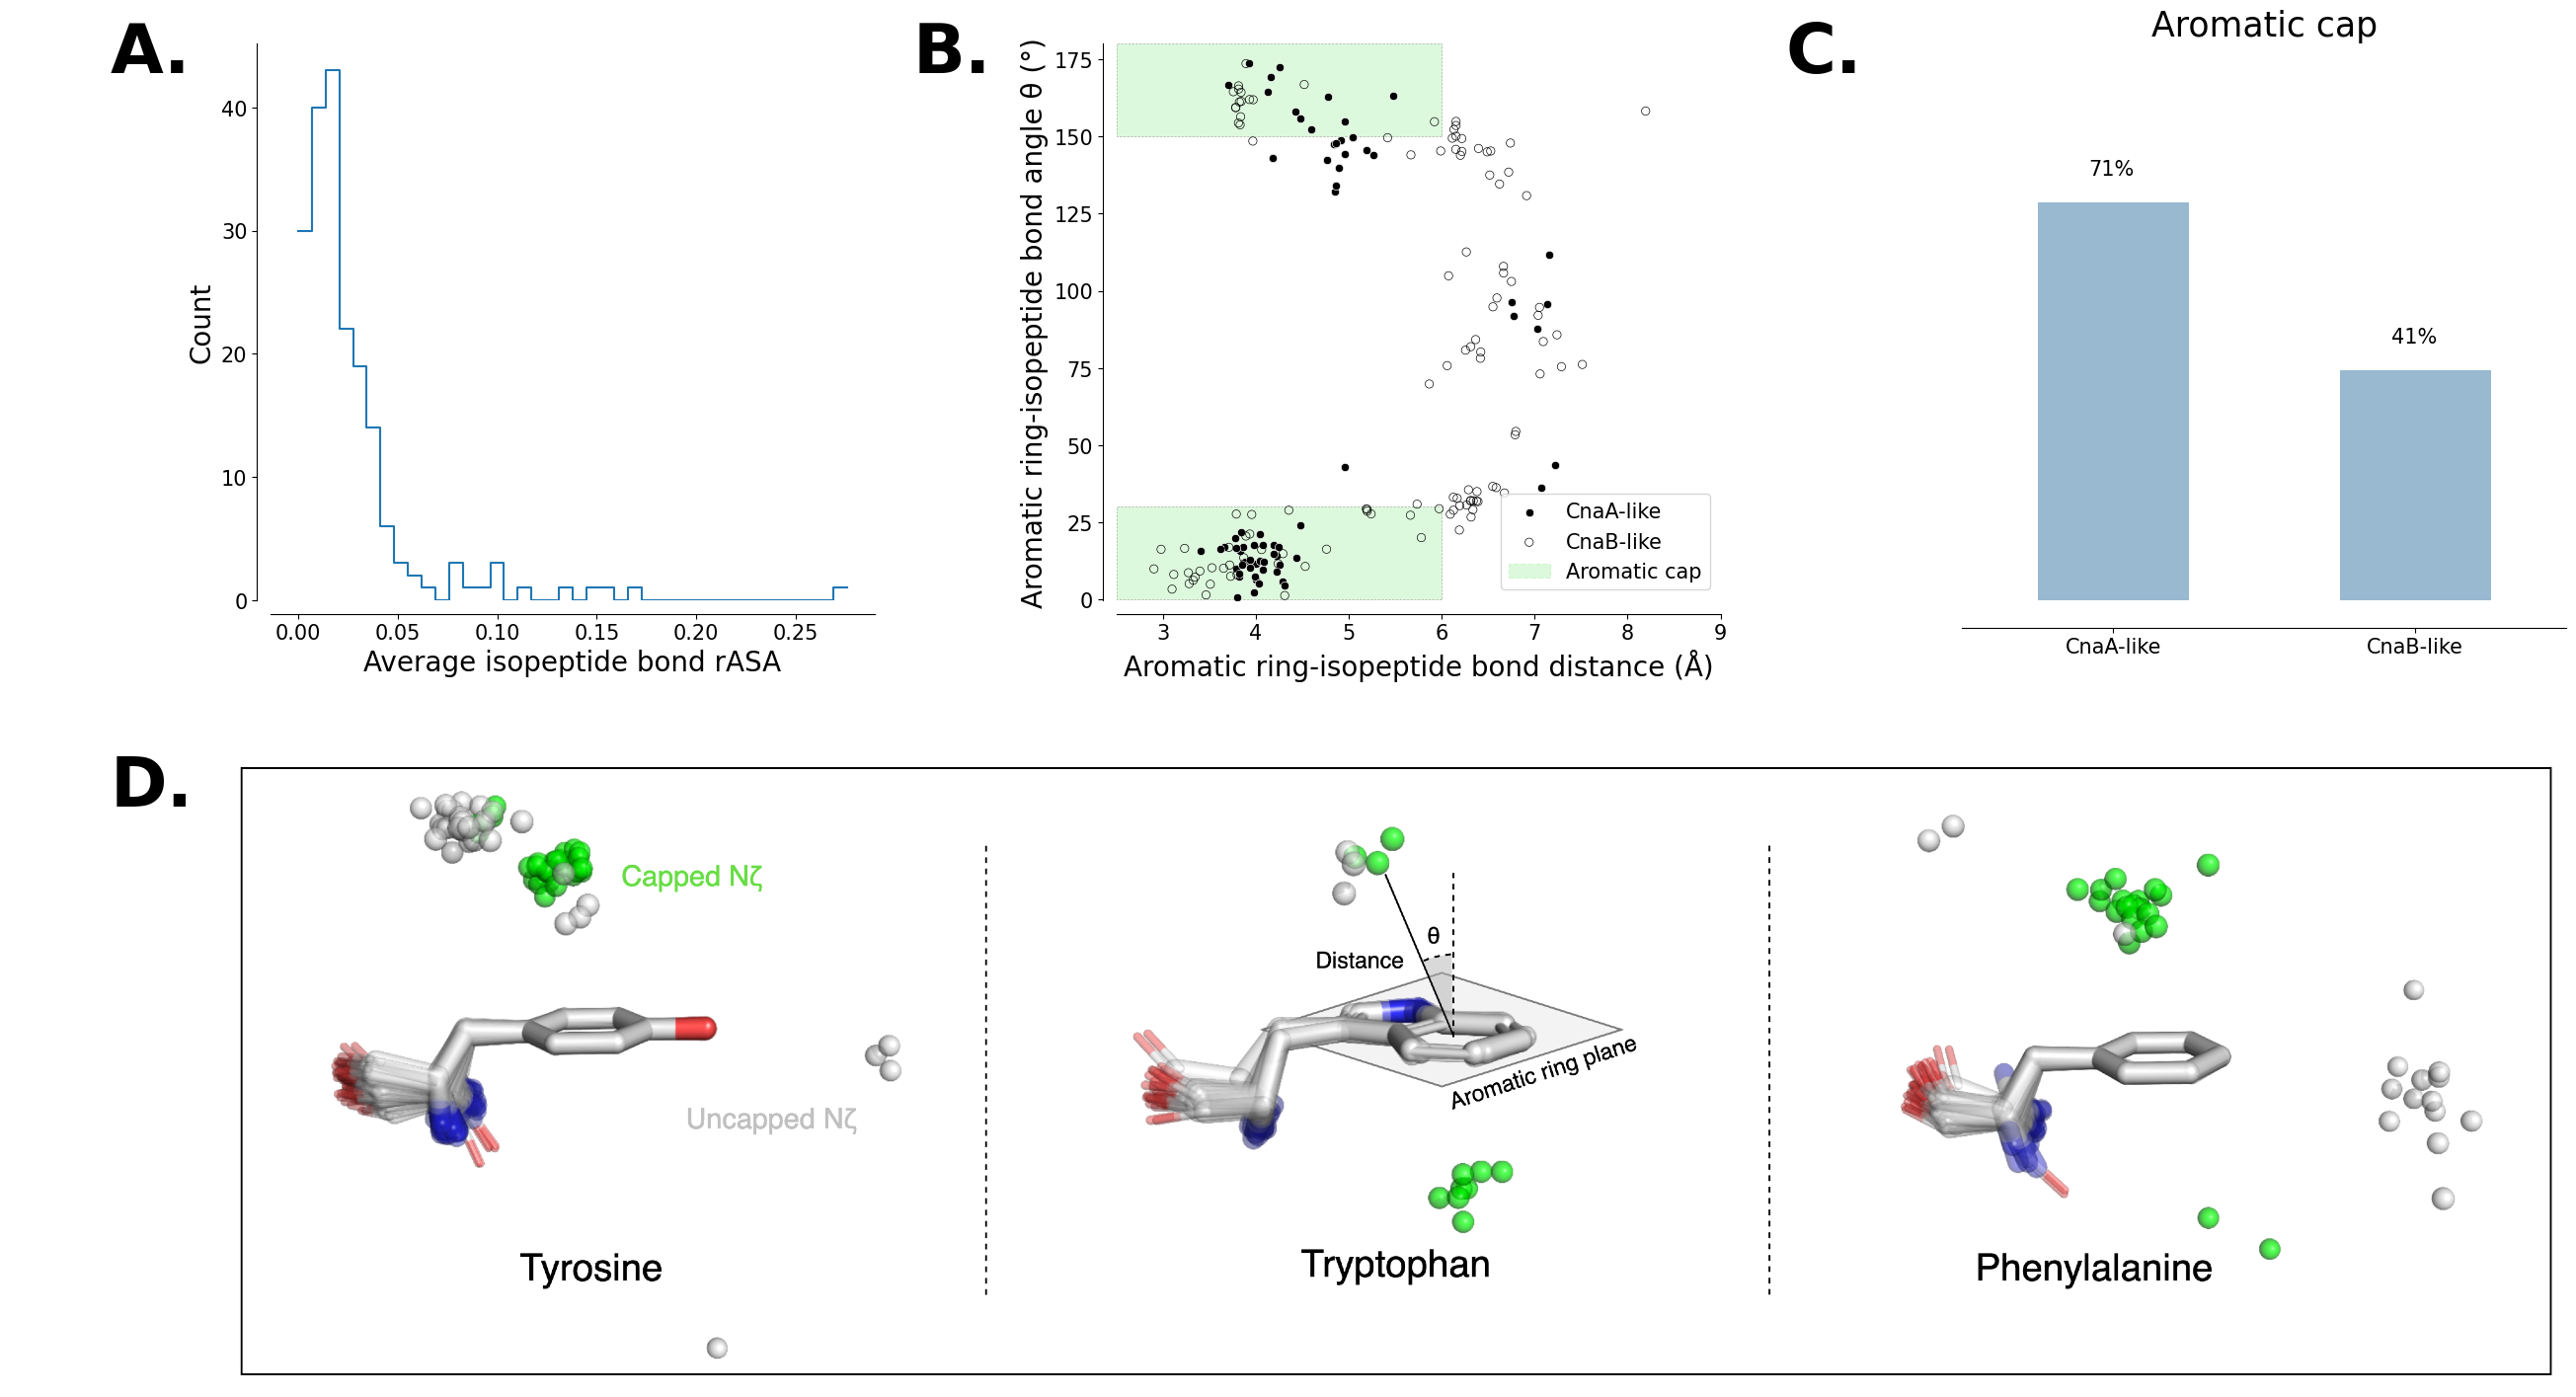

In [16]:
fig = plt.figure(figsize=[30, 15])
gs = gridspec.GridSpec(nrows=2, ncols=3, figure=fig)

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])
ax4 = fig.add_subplot(gs[1, 0:3])

# 1
ax=ax1
sns.histplot(dt_df, x="mean_rASA", ax=ax, element="step", fill=False)
ax.set_ylabel("Count")
ax.set_xlabel("Average isopeptide bond rASA")
sns.despine(ax=ax, offset=10)

# 2
ax=ax2
plot_df = dt_df[dt_df["Isopeptide type"]!="Mutant"] \
                .rename(columns={"aro_cap":"Aromatic cap"}).copy()
sns.scatterplot(plot_df[plot_df["Isopeptide type"]=="CnaA-like"], 
                y="aro_plane_normal-isopep_NZ_angle", 
                x="distance_to_aro", ax=ax,
                edgecolors="white", facecolors='black',
               label="CnaA-like")

sns.scatterplot(plot_df[plot_df["Isopeptide type"]=="CnaB-like"], 
                y="aro_plane_normal-isopep_NZ_angle", 
                x="distance_to_aro", ax=ax,
                edgecolors="black", facecolors='none',
               label="CnaB-like")

ax.set_ylim([-0.2, 180])
ax.set_xlim([2.5, 9])
ax.set_ylabel("Aromatic ring-isopeptide bond angle θ (°)")
ax.set_xlabel("Aromatic ring-isopeptide bond distance (Å)")
sns.despine(ax=ax, offset=10)

# Area of aro cap
ax.fill_betweenx([0, 30], 2.5, 6, color='lightgreen', alpha=0.3, zorder=0, lw=0.5, edgecolor="black", ls="--")
ax.fill_betweenx([150, 180], 2.5, 6, color='lightgreen', alpha=0.3, zorder=0, lw=0.5, edgecolor="black", ls="--")

# Add green square to legend
lightgreen_patch = mpatches.Patch(color='lightgreen', alpha=0.3, edgecolor="black", linestyle="--", label="Aromatic cap")
ax.legend(handles=ax.get_legend().legendHandles + [lightgreen_patch], loc="lower right")

# 3
ax = ax3
plot_df = dt_df.rename(columns={"aro_cap": "Aromatic cap"}).copy()
cond1 = (plot_df["Is bonded"])
cond2 = (plot_df["Isopeptide type"]!="Mutant")
cond3 = (~plot_df["Unusual geometry/chemistry"])
cond4 = (plot_df["Resolution"]<=2.5)
cond5 = (~plot_df["Bad rotamer"])

plot_df = plot_df[cond1 & cond2 & cond3 & cond4 & cond5] \
        .sort_values("Aromatic cap", ascending=False) \
        .drop_duplicates("isopep_sequence")\
        .groupby(["Isopeptide type"]) \
        .value_counts(["Aromatic cap"], normalize=True) \
        .reset_index()
plot_df["Percent"] = plot_df["proportion"].mul(100)

plot_df = plot_df[plot_df["Aromatic cap"]==True].pivot(columns="Aromatic cap", values="Percent", index="Isopeptide type")\
    .reindex(columns=[True], level="first")
sns.barplot(data=plot_df, y=True, x="Isopeptide type", ax=ax, hue="Isopeptide type",
            legend=False, palette=["C0", "C0"], alpha=.5, width=.5)

# Annot
y = plot_df[(plot_df.index == "CnaA-like")][True].iloc[0]
ax.text(x=0-.08, y=y+5, s=f"{round(y)}%")
y = plot_df[(plot_df.index == "CnaB-like")][True].iloc[0]
ax.text(x=1-.08, y=y+5, s=f"{round(y)}%")

ax.set_ylim([0,100])
ax.set_title("Aromatic cap")
ax.set_xlabel("")
ax.set_ylabel("")
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
sns.despine(ax=ax, offset=20, left=True)
ax.set_yticks([],[])

# 4
ax = ax4
ax.axis("off")
arr_img = plt.imread(os.path.join(INPUT_FIGURES, "fig2D.png"))
# Rotate
#arr_img = ndimage.rotate(arr_img, -3.8)
im = OffsetImage(arr_img, zoom=.46)
ab = AnnotationBbox(im, xy=(0, 0), xybox=(-.11, -.35), box_alignment=(0, 0), bboxprops=dict(color="white"))
ax.add_artist(ab)

###
plt.subplots_adjust(hspace=0.05, wspace=.4)
plt.text(-.07, 2, "A.", fontsize=ANNOT_FONT_SIZE, weight="bold")
plt.text(.28, 2, "B.", fontsize=ANNOT_FONT_SIZE, weight="bold")
plt.text(.66, 2, "C.", fontsize=ANNOT_FONT_SIZE, weight="bold")
plt.text(-0.07, .68, "D.", fontsize=ANNOT_FONT_SIZE, weight="bold")

plt.savefig(os.path.join(FIGURES, "f2.png"), dpi=300, bbox_inches="tight", pad_inches=0, transparent=True)

## Figure 3

/tmp/ipykernel_766172/3313593655.py:169: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([10**eval(i.get_text()) for i in ax.get_yticklabels()])


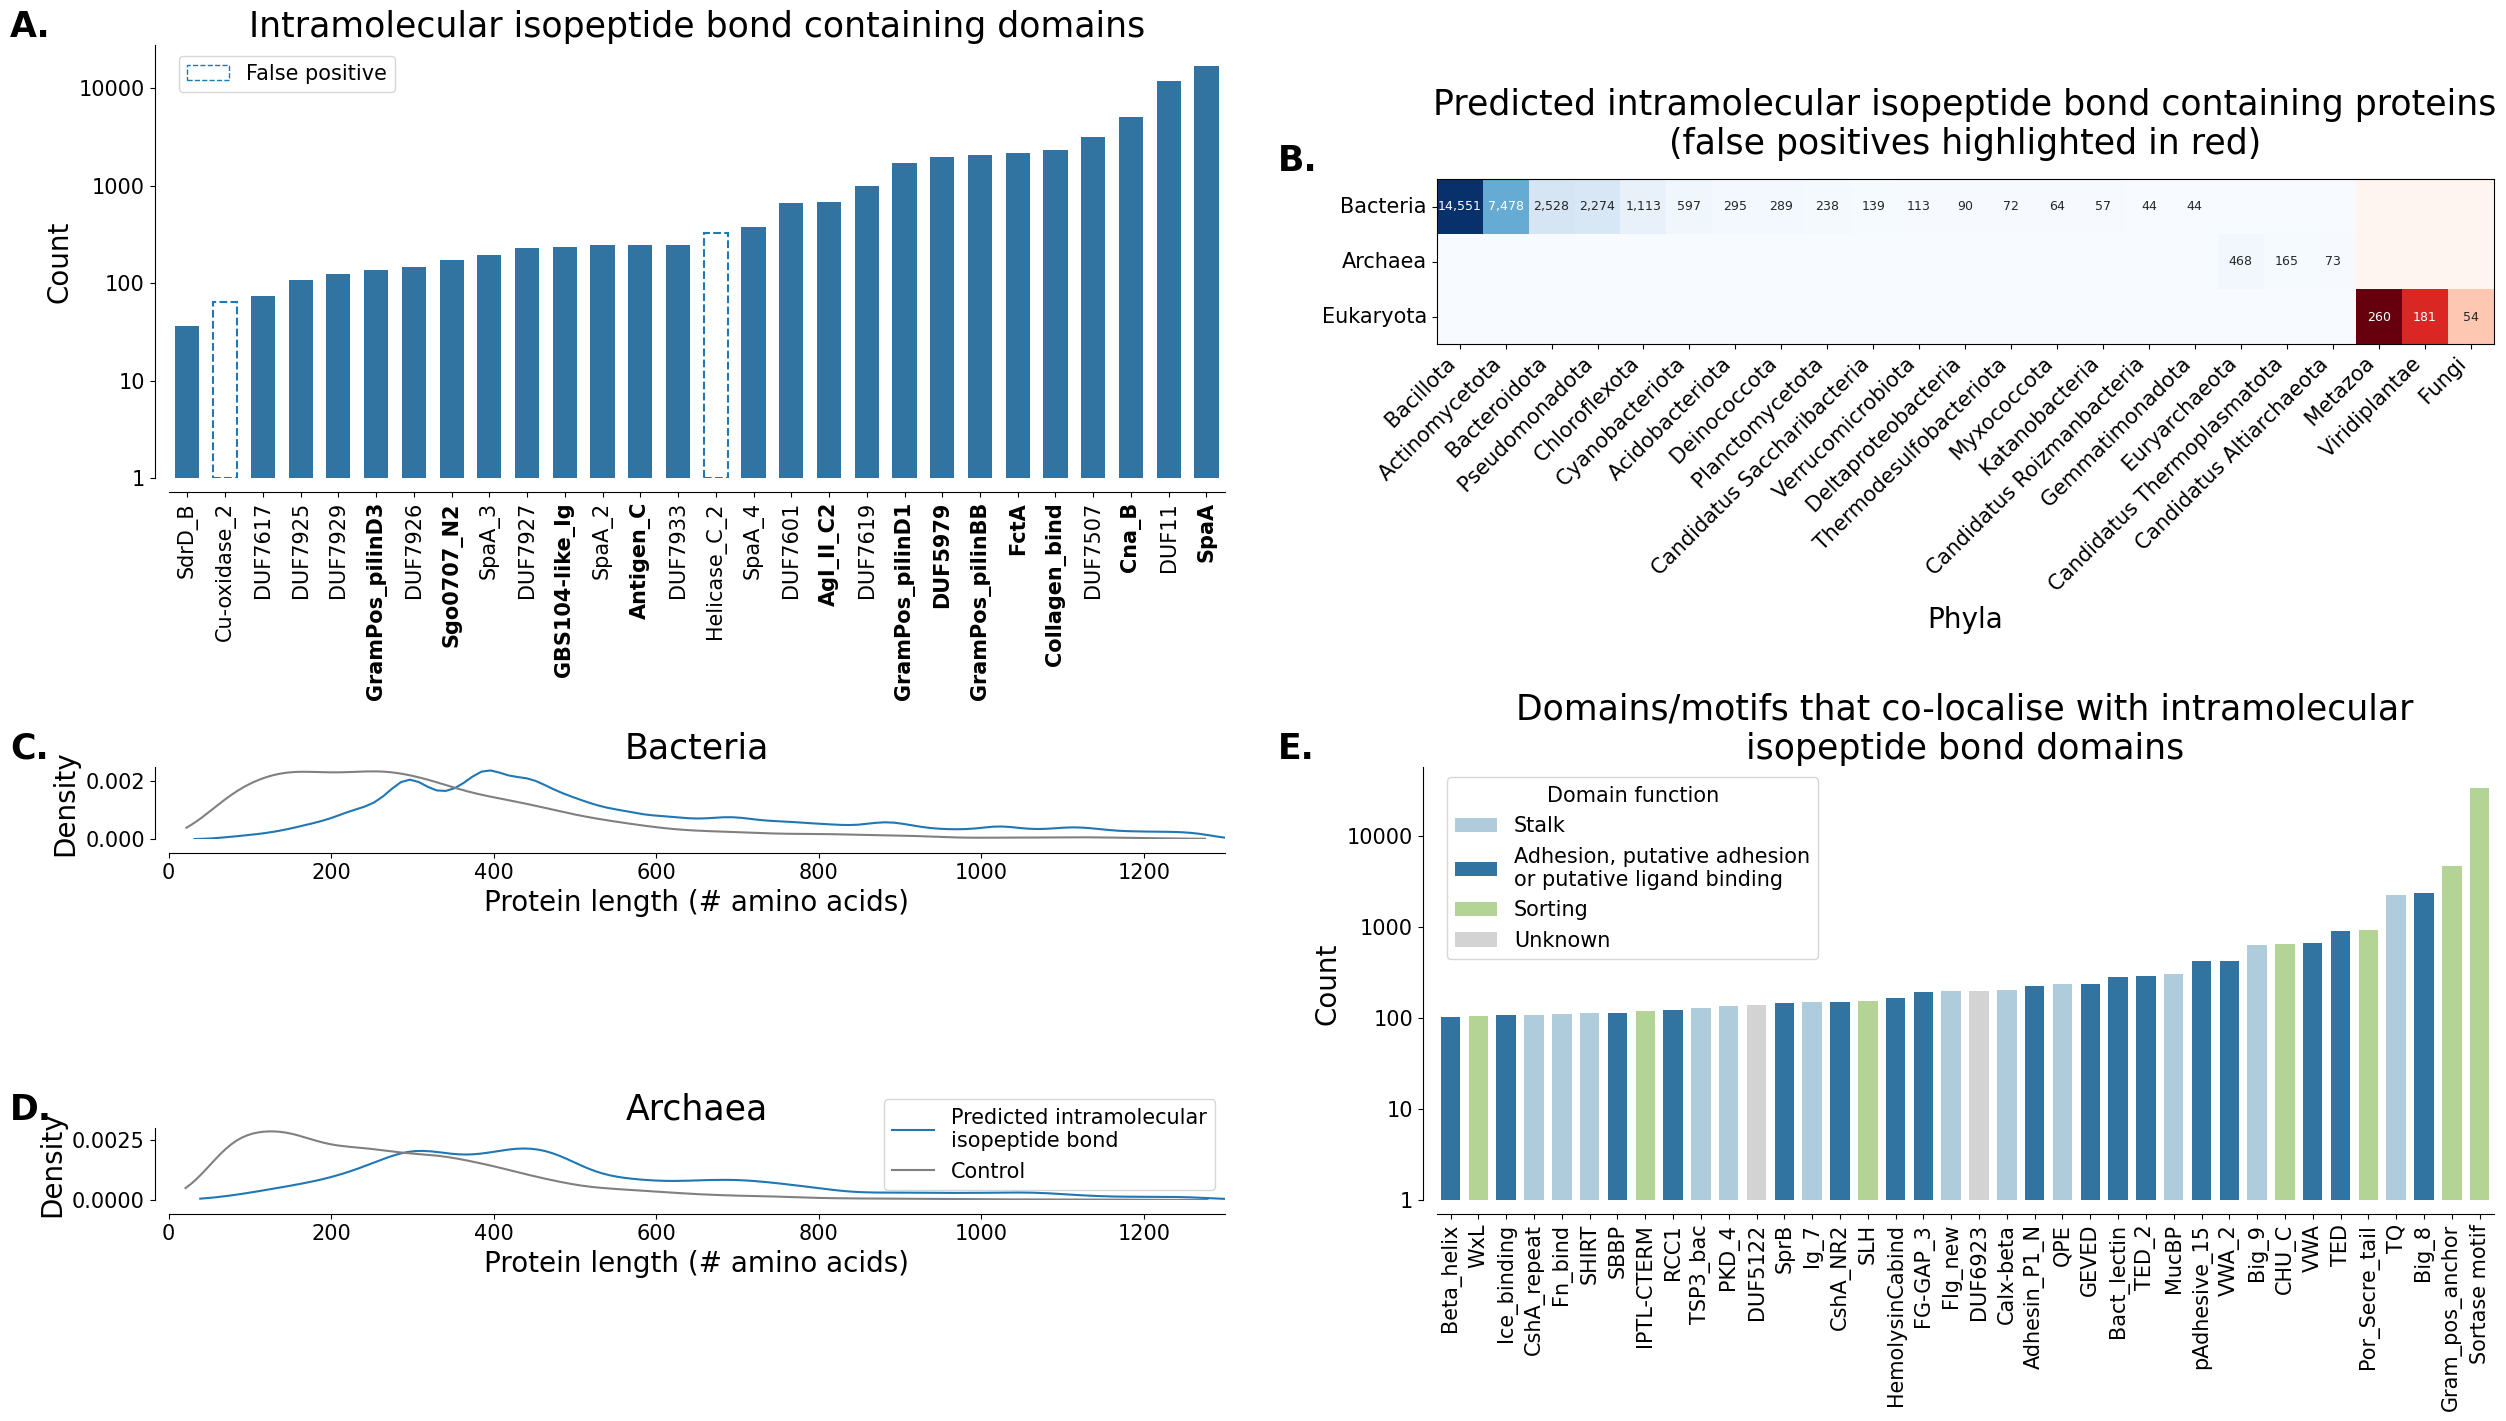

In [15]:
fig = plt.figure(figsize=[30, 15])
gs = gridspec.GridSpec(nrows=4, ncols=2, figure=fig)

ax1 = fig.add_subplot(gs[0:2, 0:1])
ax2 = fig.add_subplot(gs[0:2, 1:2])
ax3 = fig.add_subplot(gs[2:3, 0:1])
ax4 = fig.add_subplot(gs[3:4, 0:1])
ax5 = fig.add_subplot(gs[2:4, 1:2])

#1
ax = ax1

plot_df = str_df[(str_df["probability"]>.65)&(~str_df["taxonomy"].isna())] \
                .value_counts(["pfamA_id"]).reset_index()\
                .query('count>=20')
plot_df["Pfam domain id"] = plot_df["pfamA_id"] #.replace({"DUF11":"CLIPPER", "DUF7507":"CLIPPER_2"})
plot_df["Log count"] = plot_df["count"].apply(np.log10)


# Order
order = plot_df.groupby("Pfam domain id").sum("count").reset_index().sort_values("count")["Pfam domain id"]
cat_dtype = CategoricalDtype(
            categories=order, ordered=True)
plot_df["Pfam domain id"] = plot_df["Pfam domain id"].astype(cat_dtype)

# Reduce alpha of non IBDs
g=sns.barplot(data=plot_df, x="Pfam domain id", y="Log count",
            color="C0",
            dodge=True,
            ax=ax, legend=False, gap=.2, ls="-", lw=1.5)


fills = [False if domain in non_isopep else True for domain in \
         plot_df.sort_values(["Pfam domain id"])["Pfam domain id"]]

for bar, fill in zip(ax.containers[0], fills):
    if not fill:
        bar.set_linestyle("--")
        bar.set_color("C0")
        bar.set_fill(fill)

#template_patch = mpatches.Patch(color='C0', label='Template')
false_positive_patch = mpatches.Patch(facecolor='none', edgecolor='C0', linestyle='--', label='False positive')
ax.legend(handles=[false_positive_patch])

ax.tick_params(axis='x', rotation=90)
sns.despine(ax=ax, offset=10)
ax.set_ylabel("Count")
ax.set_xlabel("")
ax.set_title("Intramolecular isopeptide bond containing domains")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
# Re-transform log count
ax.set_yticks([0, 1, 2, 3, 4], [0, 1, 2, 3, 4])
ax.set_yticklabels([10**eval(i.get_text()) for i in ax.get_yticklabels()])

# Set bold for known domains:
for t in ax.get_xticklabels():
    if t.get_text() in prev_known_isopep:
        t.set_fontweight("bold")

# 2
ax = ax2
# Exclude non isopep
plot_df = str_df[(str_df["probability"]>.65)&(~str_df["taxonomy"].isna())].drop_duplicates("uniprot_acc").copy()
plot_df["phyla"] = plot_df["taxonomy"].apply(lambda x: x.split(";")[1].replace(".", "") if len(x.split(";")) >= 2 else np.NaN)
plot_df = plot_df.value_counts(["kingdom", "phyla"]).reset_index()\
                 .query('count>=40&kingdom!="unclassified sequences"&phyla!=" environmental samples"')\
                 .pivot(index="phyla", columns="kingdom", values="count").fillna(0).astype(int)\
                 [["Bacteria", "Archaea", "Eukaryota"]]\
                 .sort_values(["Bacteria", "Archaea", "Eukaryota"], ascending=[False, False, False]).T

false_positive_ids = [" Metazoa", " Viridiplantae", " Fungi"]

# Create masks for false positives and non-false positives (columns-based)
false_positive_mask = plot_df.columns.isin(false_positive_ids)

# Separate data into two layers: false positives and non-false positives
false_positives_layer = plot_df.astype(float).copy()
false_positives_layer.loc[:, ~false_positive_mask] = np.nan  # Keep only false positives

non_false_positives_layer = plot_df.astype(float).copy()
non_false_positives_layer.loc[:, false_positive_mask] = np.nan  # Exclude false positives

# Create colormaps with custom "under" or "over" values
cmap_false_positives = plt.get_cmap("Reds").copy()
cmap_false_positives.set_under("none")  # Make non-values invisible

cmap_non_false_positives = plt.get_cmap("Blues").copy()
cmap_non_false_positives.set_under("none")  # Make non-values invisible

sns.heatmap(non_false_positives_layer, cmap=cmap_non_false_positives, 
            ax=ax, annot=True, annot_kws={'fontsize': 9}, fmt=",.0f", cbar=False)

g=sns.heatmap(false_positives_layer, cmap=cmap_false_positives, 
            ax=ax, annot=True, annot_kws={'fontsize': 9}, fmt=",.0f", cbar=False)

g.set_yticklabels(g.get_yticklabels(), rotation=0)
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
ax.set_aspect(1.2)
#ax.set_position(pos=[0.375,.54,.5,.5])
ax.set_title("Predicted intramolecular isopeptide bond containing proteins\n(false positives highlighted in red)", y=1.1) # pad is not being recognised
ax.set_ylabel("")
ax.set_xlabel("Phyla")

# Add countour lines
for _, spine in ax.spines.items():
    spine.set_visible(True)
# Mask 0s
for text in ax.texts:
    if text.get_text() == '0':
        text.set_visible(False)

# 3,4
for ax, kingdom in zip([ax3, ax4], ["Bacteria", "Archaea"]):
    sns.kdeplot(seq_df[seq_df["kingdom"]==kingdom], x="len", label="Predicted intramolecular\nisopeptide bond", ax=ax, cut=0, color="C0")
    sns.kdeplot(random_seqs_df[random_seqs_df["kingdom"]==kingdom], x="length", label="Control", ax=ax, cut=0, color="gray")
    ax.set_title(kingdom)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    sns.despine(ax=ax, offset=10)
    ax.set_xlabel("Protein length (# amino acids)")
    ax.set_xlim([0,1300])
ax.legend()

# 5
ax = ax5

# All domains from IB-containing proteins, excluding IB-containing domains
# Exclude domains associated with known false positives (non_isopep)
# Include domains associated with unknonwn isopep domains
ib_proteins = str_df[(str_df["probability"]>.65)&(str_df["kingdom"].isin(["Bacteria", "Archaea"]))&(~str_df["pfamA_id"].isin(non_isopep))]["uniprot_acc"].unique()
ib_domains = str_df[(str_df["probability"]>.65)&(str_df["kingdom"].isin(["Bacteria", "Archaea"]))&(~str_df["pfamA_id"].isin(non_isopep))]["pfamA_acc"].unique()
d_df_domains = strd_df[(strd_df["uniprot_acc"].isin(ib_proteins))&(~strd_df["pfamA_acc"].isin(ib_domains))]["pfamA_acc"].unique()
count_df = strd_df[(strd_df["uniprot_acc"].isin(ib_proteins))&(~strd_df["pfamA_acc"].isin(ib_domains))].value_counts(["pfamA_acc", "pfamA_id"]).reset_index()

adhesin = adh_df["pfamA_acc"].unique()
stalk = stalk_df["pfamA_acc"].unique()
sorting = ["Por_Secre_tail", "CHU_C", "Sortase motif", "Gram_pos_anchor",
            "SLH", "IPTL-CTERM", "WxL"]
putative_adhesin = ["Big_8", "VWA_2", "FG-GAP_3", "HemolysinCabind", "SprB",
                   "RCC1", "Beta_helix", "RCC1_2", "SBBP", "LTD", "NosD", "FG-GAP_2",
                   "PA", "K319L-like_PKD", "LysM", "pAdhesive_15", "TED_2",
                   "GEVED"]

plot_df = count_df.query("count>100").sort_values("count")
plot_df["count"] = plot_df["count"].apply(np.log10)
plot_df["Domain function"] = "Unknown"
# MErge adhesion and putative adhesion
plot_df.loc[plot_df["pfamA_acc"].isin(adhesin), "Domain function"] = "Adhesion, putative adhesion\nor putative ligand binding"
plot_df.loc[plot_df["pfamA_id"].isin(putative_adhesin), "Domain function"] = "Adhesion, putative adhesion\nor putative ligand binding"
plot_df.loc[plot_df["pfamA_acc"].isin(stalk), "Domain function"] = "Stalk"
plot_df.loc[plot_df["pfamA_id"].isin(sorting), "Domain function"] = "Sorting"

cmap = sns.color_palette("Paired", 3)
g=sns.barplot(plot_df, y="count", x="pfamA_id", 
              palette={"Sorting":cmap[2], 'Stalk':cmap[0], 'Adhesion, putative adhesion\nor putative ligand binding':cmap[1],
                       'Unknown':"lightgray"}, 
              ax=ax, hue="Domain function",
              hue_order=["Stalk", "Adhesion, putative adhesion\nor putative ligand binding", "Sorting", "Unknown"],
             width=.7)
g.tick_params(axis='x', rotation=90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.despine(ax=ax, offset=10)
ax.set_xlabel("")
ax.set_title("Domains/motifs that co-localise with intramolecular\nisopeptide bond domains")
ax.set_ylabel("Count")
ax.set_yticklabels([10**eval(i.get_text()) for i in ax.get_yticklabels()])

#
for i, ax in enumerate(fig.axes, start=1):
    ax.set_title(f"{chr(64+i)}.", loc="left", fontweight='bold', x=-0.15)

plt.subplots_adjust(hspace=4, wspace=0.2)

plt.savefig(os.path.join(FIGURES, "f3.png"), dpi=400, bbox_inches="tight", pad_inches=0)

## Figure 4

In [5]:
# Get CLIPPER position along the sequence
# exclude "DUF7507" (CLIPPER_2)

tmp_df = pd.merge(str_df[(str_df["kingdom"].isin(["Bacteria", "Archaea"]))&(str_df["probability"]>.65)\
    &(str_df["pfamA_id"].isin(["DUF11"]))], seq_df[["uniprot_acc", "len"]])[["seq_start", "seq_end", "len", "kingdom", "taxonomy"]] \


tmp_df["phylum"] = tmp_df["taxonomy"].apply(lambda x: x.split(";")[1].replace(".", "") if len(x.split(";")) >= 2 else None)

# Normalise
tmp_df["seq_start"] = round(tmp_df["seq_start"] / tmp_df["len"], 3)*100
tmp_df["seq_end"] = round(tmp_df["seq_end"] / tmp_df["len"], 3)*100
tmp_df = tmp_df[["seq_start", "seq_end", "len", "kingdom", "phylum"]]

# Bin
bins = []
for index, row in tmp_df.iterrows():
    seq_start = row["seq_start"]
    seq_end = row["seq_end"]
    kingdom = row["kingdom"]
    phylum = row["phylum"]
    tmp_bin = [kingdom, phylum]
    for b in range(1, 101):
        if b >= seq_start and b <= seq_end:
            tmp_bin.append(1)
        else:
            tmp_bin.append(0)

    bins.append(tmp_bin)
bins_df = pd.DataFrame(bins, columns=["kingdom", "phylum"]+[i for i in range(1, 101)])

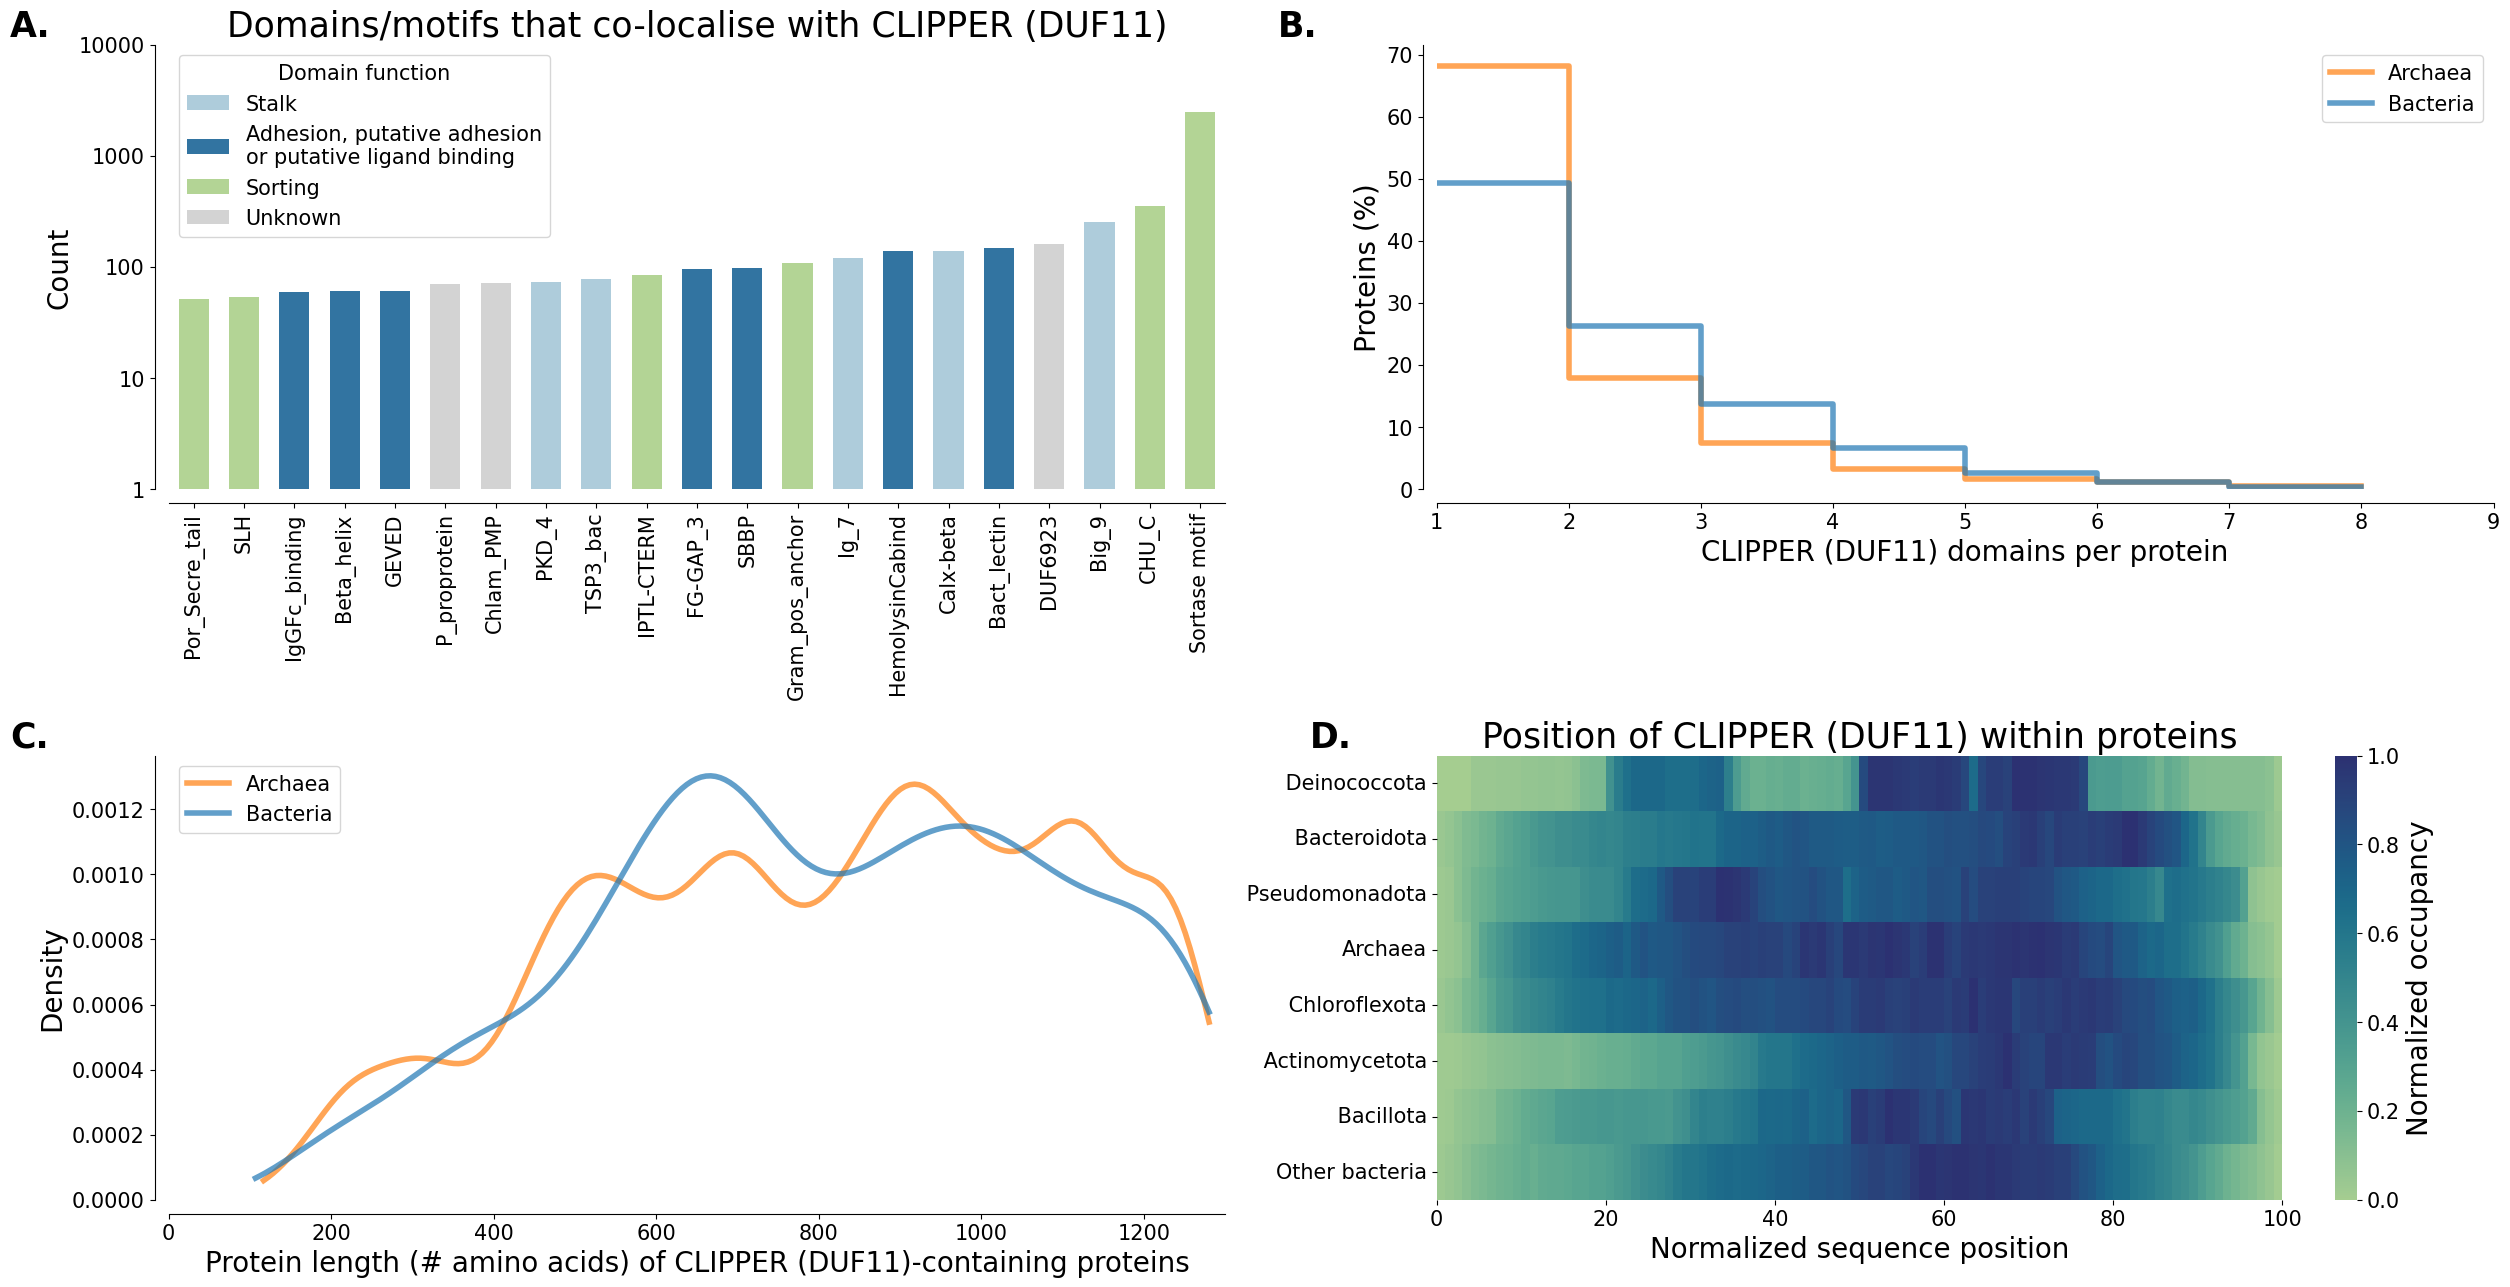

In [8]:
fig, axs = plt.subplots(figsize=[30, 15], nrows=2, ncols=2,)
plt.subplots_adjust(hspace=.6, wspace=0.2)

ax1 = axs[0,0]
ax2 = axs[0,1]
ax3 = axs[1,0]
ax4 = axs[1,1]

# 1
ax = ax1
# Domains co-localising with DUF11/DUF7507
ib_proteins = str_df[(str_df["probability"]>.65)&\
            (str_df["kingdom"].isin(["Bacteria", "Archaea"])&(str_df["pfamA_id"].isin(["DUF11"])))\
        &(~str_df["pfamA_id"].isin(non_isopep))]["uniprot_acc"].unique()
ib_domains = str_df[(str_df["probability"]>.65)&(str_df["kingdom"]\
                                    .isin(["Bacteria", "Archaea"]))&(~str_df["pfamA_id"].isin(non_isopep))]["pfamA_acc"].unique()
d_df_domains = strd_df[(strd_df["uniprot_acc"].isin(ib_proteins))&(~strd_df["pfamA_acc"].isin(ib_domains))]["pfamA_acc"].unique()
count_df = strd_df[(strd_df["uniprot_acc"].isin(ib_proteins))&(~strd_df["pfamA_acc"].isin(ib_domains))].value_counts(["pfamA_acc", "pfamA_id"]).reset_index()
adhesin = adh_df["pfamA_acc"].unique()
stalk = stalk_df["pfamA_acc"].unique()
sorting = ["Por_Secre_tail", "CHU_C", "Sortase motif", "Gram_pos_anchor",
            "SLH", "IPTL-CTERM", "WxL"]
putative_adhesin = ["Big_8", "VWA_2", "FG-GAP_3", "HemolysinCabind", "SprB",
                   "RCC1", "Beta_helix", "RCC1_2", "SBBP", "LTD", "NosD", "FG-GAP_2",
                   "PA", "K319L-like_PKD", "LysM", "pAdhesive_15", "TED_2",
                   "GEVED", "IgGFc_binding"]

plot_df = count_df.query("count>50").sort_values("count")
plot_df["count"] = plot_df["count"].apply(np.log10)
plot_df["Domain function"] = "Unknown"
# MErge adhesion and putative adhesion
plot_df.loc[plot_df["pfamA_acc"].isin(adhesin), "Domain function"] = "Adhesion, putative adhesion\nor putative ligand binding"
plot_df.loc[plot_df["pfamA_id"].isin(putative_adhesin), "Domain function"] = "Adhesion, putative adhesion\nor putative ligand binding"
plot_df.loc[plot_df["pfamA_acc"].isin(stalk), "Domain function"] = "Stalk"
plot_df.loc[plot_df["pfamA_id"].isin(sorting), "Domain function"] = "Sorting"

cmap = sns.color_palette("Paired", 3)
g=sns.barplot(plot_df, y="count", x="pfamA_id", 
              palette={"Sorting":cmap[2], 'Stalk':cmap[0], 'Adhesion, putative adhesion\nor putative ligand binding':cmap[1],
                       'Unknown':"lightgray"}, 
              ax=ax, hue="Domain function",
              hue_order=["Stalk", "Adhesion, putative adhesion\nor putative ligand binding", "Sorting", "Unknown"],
             width=.6)

g.tick_params(axis='x', rotation=90)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.despine(ax=ax, offset=10)
ax.set_xlabel("")
ax.set_title("Domains/motifs that co-localise with CLIPPER (DUF11)")
ax.set_ylabel("Count")
ax.set_yticks([0, 1, 2, 3, 4], [0, 1, 2, 3, 4])
ax.set_yticklabels([10**eval(i.get_text()) for i in ax.get_yticklabels()])

# 2
ax = ax2

plot_df = str_df[(str_df["kingdom"].isin(["Bacteria", "Archaea"]))&(str_df["probability"]>.65)\
    &(str_df["pfamA_id"].isin(["DUF11"]))].value_counts(["kingdom", "uniprot_acc"]).reset_index()

sns.histplot(plot_df, x="count", fill=False, element='step', bins=7, hue="kingdom", 
            hue_order=["Archaea", "Bacteria"], common_norm=False, stat="percent", 
            ax=ax, lw=4, alpha=.7)

ax.set_xlabel("CLIPPER (DUF11) domains per protein")
ax.set_ylabel("Proteins (%)")
#ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
sns.despine(offset=10, ax=ax)
ax.set_xlim([1,9])
ax.legend(title='', labels=["Archaea", "Bacteria"])

# 3
ax = ax3
clipper_proteins = str_df[(str_df["kingdom"].isin(["Bacteria", "Archaea"]))&(str_df["probability"]>.65)\
    &(str_df["pfamA_id"].isin(["DUF11"]))]["uniprot_acc"].unique()
sns.kdeplot(seq_df[seq_df["uniprot_acc"].isin(clipper_proteins)], x="len", ax=ax, cut=0,
    hue="kingdom", hue_order=["Archaea", "Bacteria"], common_norm=False, lw=4, alpha=.7)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
sns.despine(ax=ax, offset=10)
ax.legend(title='', labels=["Archaea", "Bacteria"])
ax.set_xlabel("Protein length (# amino acids) of CLIPPER (DUF11)-containing proteins")
ax.set_xlim([0,1300])

# 4
ax = ax4
# Consider first 6 for Bac
phylum_to_consider = bins_df[bins_df["kingdom"]=="Bacteria"].value_counts(["kingdom", "phylum"]).reset_index()["phylum"].to_list()[:6]

plot_df = bins_df.copy()
plot_df.loc[plot_df["kingdom"]=="Archaea", "phylum"] = "Archaea"
plot_df.loc[(~plot_df["phylum"].isin(phylum_to_consider))&(plot_df["kingdom"]=="Bacteria"), "phylum"] = "Other bacteria"
plot_df.loc[(plot_df["phylum"].str.contains("Candidatus"))&(plot_df["kingdom"]=="Bacteria"), "phylum"] = "Other bacteria"
plot_df = plot_df.groupby(["kingdom", "phylum"]).sum()
# Normalise by max row value
plot_df = plot_df.div(plot_df.max(axis=1), axis=0).round(2).reset_index().set_index("phylum")
plot_df.pop("kingdom")
# Perform hierarchical clustering on rows
linkage_matrix = sch.linkage(plot_df, method='ward')
# Get the order of rows based on clustering
dendro = sch.dendrogram(linkage_matrix, no_plot=True)
row_order = dendro['leaves']
# Reorder the dataframe
plot_df_clustered = plot_df.iloc[row_order]
g=sns.heatmap(plot_df_clustered, cmap="crest", ax=ax, cbar_kws={"label": "Normalized occupancy"})
ax.set_ylabel("")
ax.set_xlabel("Normalized sequence position")
ax.set_xticks([i for i in range(0, 101, 20)], 
             [i for i in range(0, 101, 20)])
g.tick_params(axis='x', rotation=0)
ax.set_title("Position of CLIPPER (DUF11) within proteins", pad=20)

for i, ax in enumerate(fig.axes[:-1], start=1):
    ax.set_title(f"{chr(64+i)}.", loc="left", fontweight='bold', x=-0.15)

plt.savefig(os.path.join(FIGURES, "f4.png"), dpi=350, bbox_inches="tight", pad_inches=0)

## Figure S5

In [19]:
import matplotlib.text as mtext

class LegendTitle(object):
    """
    
        Handles row and column naming

    """
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, y0, orig_handle, **self.text_props)
        handlebox.add_artist(title)
        return title

In [20]:
# Do at phylum level to constrain to a reasonable amount to display
str_df["superkingdom"] = str_df["taxonomy"].apply(lambda x: str(x).split(";")[0].replace(".", "").strip() if len(str(x).split(";")) >= 1 else None)
str_df["phylum"] = str_df["taxonomy"].apply(lambda x: str(x).split(";")[1].replace(".", "").strip() if len(str(x).split(";")) >= 5 else None)
str_df["class"] = str_df["taxonomy"].apply(lambda x: str(x).split(";")[-2].replace(".", "").strip() if len(str(x).split(";")) >= 5 else None)
str_df["genus"] = str_df["taxonomy"].apply(lambda x: str(x).split(";")[-1].replace(".", "").strip() if len(str(x).split(";")) >= 5 else None)

archaea = str_df[(str_df["probability"]>0.65)&(str_df["kingdom"]=="Archaea")]\
    .drop_duplicates("uniprot_acc")\
    .value_counts(["phylum", "kingdom"])\
    .reset_index()["phylum"] \
    .to_list()
    #.query("count>10")["genus"]\
bacteria = str_df[(str_df["probability"]>0.65)&(str_df["kingdom"]=="Bacteria")]\
    .drop_duplicates("uniprot_acc")\
    .value_counts(["phylum", "kingdom"])\
    .reset_index()["phylum"] \
    .to_list()
    #.query("count>100")["genus"]\

In [21]:
# Counts of domains co-localising with IB domains per organism genus

ib_proteins = str_df[(str_df["probability"]>.65)&(str_df["superkingdom"].isin(["Bacteria", "Archaea"]))&(~str_df["pfamA_id"].isin(non_isopep))]["uniprot_acc"].unique()
ib_domains = str_df[(str_df["probability"]>.65)&(str_df["superkingdom"].isin(["Bacteria", "Archaea"]))&(~str_df["pfamA_id"].isin(non_isopep))]["pfamA_acc"].unique()
d_df_domains = strd_df[(strd_df["uniprot_acc"].isin(ib_proteins))&(~strd_df["pfamA_acc"].isin(ib_domains))]["pfamA_acc"].unique()
count_df = strd_df[(strd_df["uniprot_acc"].isin(ib_proteins))&(~strd_df["pfamA_acc"].isin(ib_domains))]
# Add genus information
count_df = pd.merge(count_df, str_df[["uniprot_acc", "superkingdom", "phylum"]]).drop_duplicates()

# Group genera with low counts into other archaea/bacteria
#count_df.loc[(count_df["kingdom"]=="Archaea")&(~count_df["genus"].isin(archaea)), "genus"] = "Other archaea"
#count_df.loc[(count_df["kingdom"]=="Bacteria")&(~count_df["genus"].isin(bacteria)), "genus"] = "Other bacteria"

# Count values
plot_df = count_df.value_counts(["superkingdom", "phylum", "pfamA_acc", "pfamA_id"]).reset_index()

adhesin = adh_df["Name"].unique()
stalk = stalk_df["Name"].unique()
sorting = ["Por_Secre_tail", "CHU_C", "Sortase motif", "Gram_pos_anchor",
            "SLH", "IPTL-CTERM", "WxL", "YSIRK_signal"]
putative_adhesin = ["Big_8", "VWA_2", "FG-GAP_3", "HemolysinCabind", "SprB",
                   "RCC1", "Beta_helix", "RCC1_2", "SBBP", "LTD", "NosD", "FG-GAP_2",
                   "PA", "K319L-like_PKD", "LysM", "pAdhesive_15", "TED_2",
                   "GEVED", "IgGFc_binding", "YNCE", "TSP_3"]

plot_df["Domain function"] = "Unknown/other function"
# MErge adhesion and putative adhesion
plot_df.loc[plot_df["pfamA_id"].isin(adhesin), "Domain function"] = "Adhesion, putative adhesion\nor putative ligand binding"
plot_df.loc[plot_df["pfamA_id"].isin(putative_adhesin), "Domain function"] = "Adhesion, putative adhesion\nor putative ligand binding"
plot_df.loc[plot_df["pfamA_id"].isin(stalk), "Domain function"] = "Stalk"
plot_df.loc[plot_df["pfamA_id"].isin(sorting), "Domain function"] = "Sorting"

# Consider only domains with more than X counts (and all archaea domains)
domains_to_consider = list(plot_df[plot_df["superkingdom"]=="Archaea"]["pfamA_id"].unique()) + list(plot_df[plot_df["count"]>50]["pfamA_id"].unique())
plot_df = plot_df[plot_df["pfamA_id"].isin(domains_to_consider)]\
    .sort_values(["Domain function", "count"], ascending=[True, False])\
    .pivot(index=["superkingdom", "phylum"], 
            columns=["Domain function", "pfamA_id"], values="count").fillna(0).astype(int)
# Apply log10 and replace inf with 0
plot_df = plot_df.apply(np.log10)

# Invert 
plot_df = plot_df.T

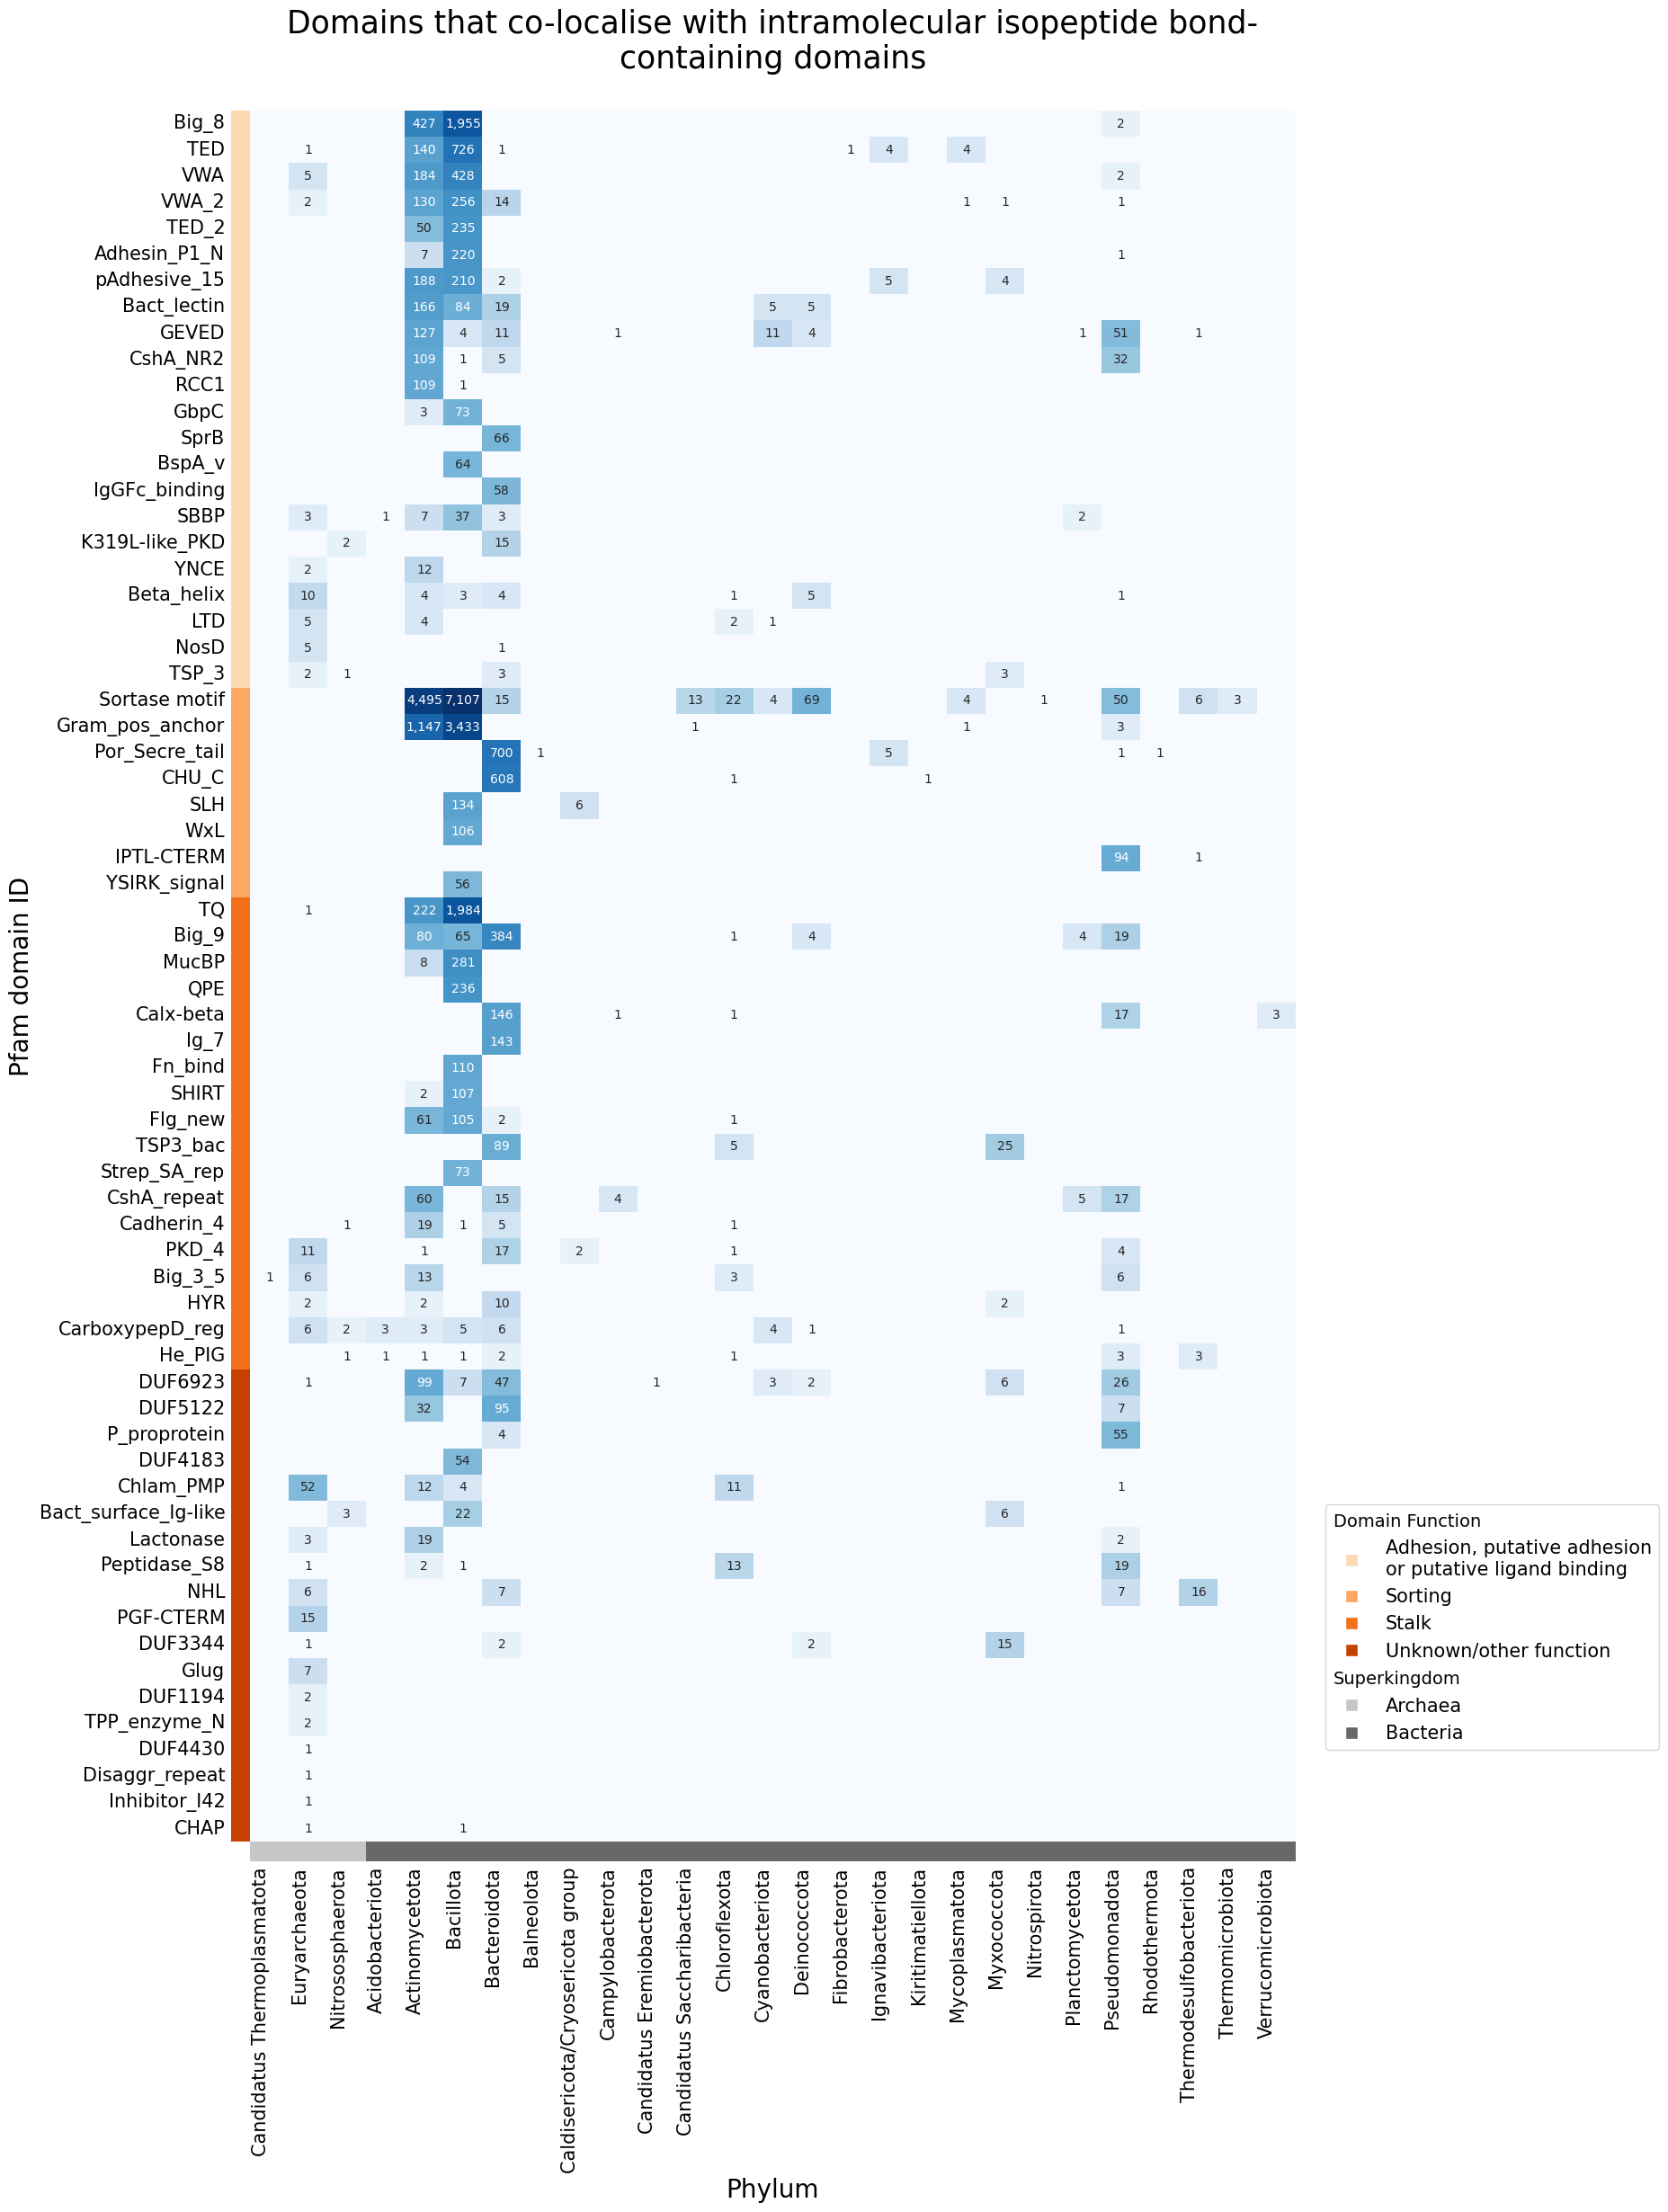

In [25]:
# Define color mappings
domain_functions = plot_df.index.get_level_values(0).unique()
superkingdoms = plot_df.columns.get_level_values(0).unique()

col_lut = dict(zip(superkingdoms, sns.color_palette("Grays", n_colors=len(superkingdoms))))
row_lut = dict(zip(domain_functions, sns.color_palette("Oranges", n_colors=len(domain_functions))))

row_colors = plot_df.index.get_level_values(0).map(row_lut)
col_colors = plot_df.columns.get_level_values(0).map(col_lut)

fig, ax = plt.subplots(figsize=[15, 25])

filled_df = plot_df.replace([np.inf, -np.inf], 0)
g=sns.heatmap(
    filled_df,
    cmap="Blues",
    annot=np.vectorize(lambda x: 10**x)(plot_df),
    fmt=",.0f",
    annot_kws={"fontsize": 10},
)

# Hide text for 0
for text in ax.texts:
    if text.get_text() == "0":
        text.set_visible(False)

g.collections[0].colorbar.remove()
# Adjust y-axis tick labels
ax.tick_params(axis='y', which='major', pad=20, length=0)
ax.set_yticklabels(plot_df.index.get_level_values(1), rotation=0)

# Adjust x-axis tick labels
ax.tick_params(axis='x', which='major', pad=20, length=0)
ax.set_xticklabels(plot_df.columns.get_level_values(1), rotation=90, ha="right")

# Add row color indexing right next to the heatmap
for i, color in enumerate(row_colors):
    ax.add_patch(plt.Rectangle(xy=(-0.5, i), width=0.5, height=1, color=color, lw=0,
                               transform=ax.transData, clip_on=False))

# Add column color indexing on top of the heatmap
for i, color in enumerate(col_colors):
    ax.add_patch(plt.Rectangle(xy=(i, -0.0115), width=1, height=0.0115, color=color, lw=0,
                               transform=ax.get_xaxis_transform(), clip_on=False))

# Legend
row_handles, row_labels = zip(*[(plt.Line2D([0], [0], marker='s', color='w', 
                                            markerfacecolor=row_lut[k], markersize=10), k) 
                                for k in row_lut.keys()])

col_handles, col_labels = zip(*[(plt.Line2D([0], [0], marker='s', color='w', 
                                            markerfacecolor=col_lut[k], markersize=10), k) 
                                for k in col_lut.keys()])

# Merge legends
handles = ['Domain Function'] + list(row_handles) + ['Superkingdom'] + list(col_handles)
labels = [''] + list(row_labels) + [''] + list(col_labels)

# Create final legend
ax.legend(handles, labels, handler_map={str: LegendTitle({'fontsize': 14})}, 
          bbox_to_anchor=(1.02, .2), loc='upper left', frameon=True)

ax.set_title("Domains that co-localise with intramolecular isopeptide bond-\ncontaining domains", y=1.02)
ax.set_xlabel("Phylum")
ax.set_ylabel("Pfam domain ID")

plt.savefig(os.path.join(FIGURES, "sf5.png"), dpi=350, bbox_inches="tight", pad_inches=0)

## Figure S1

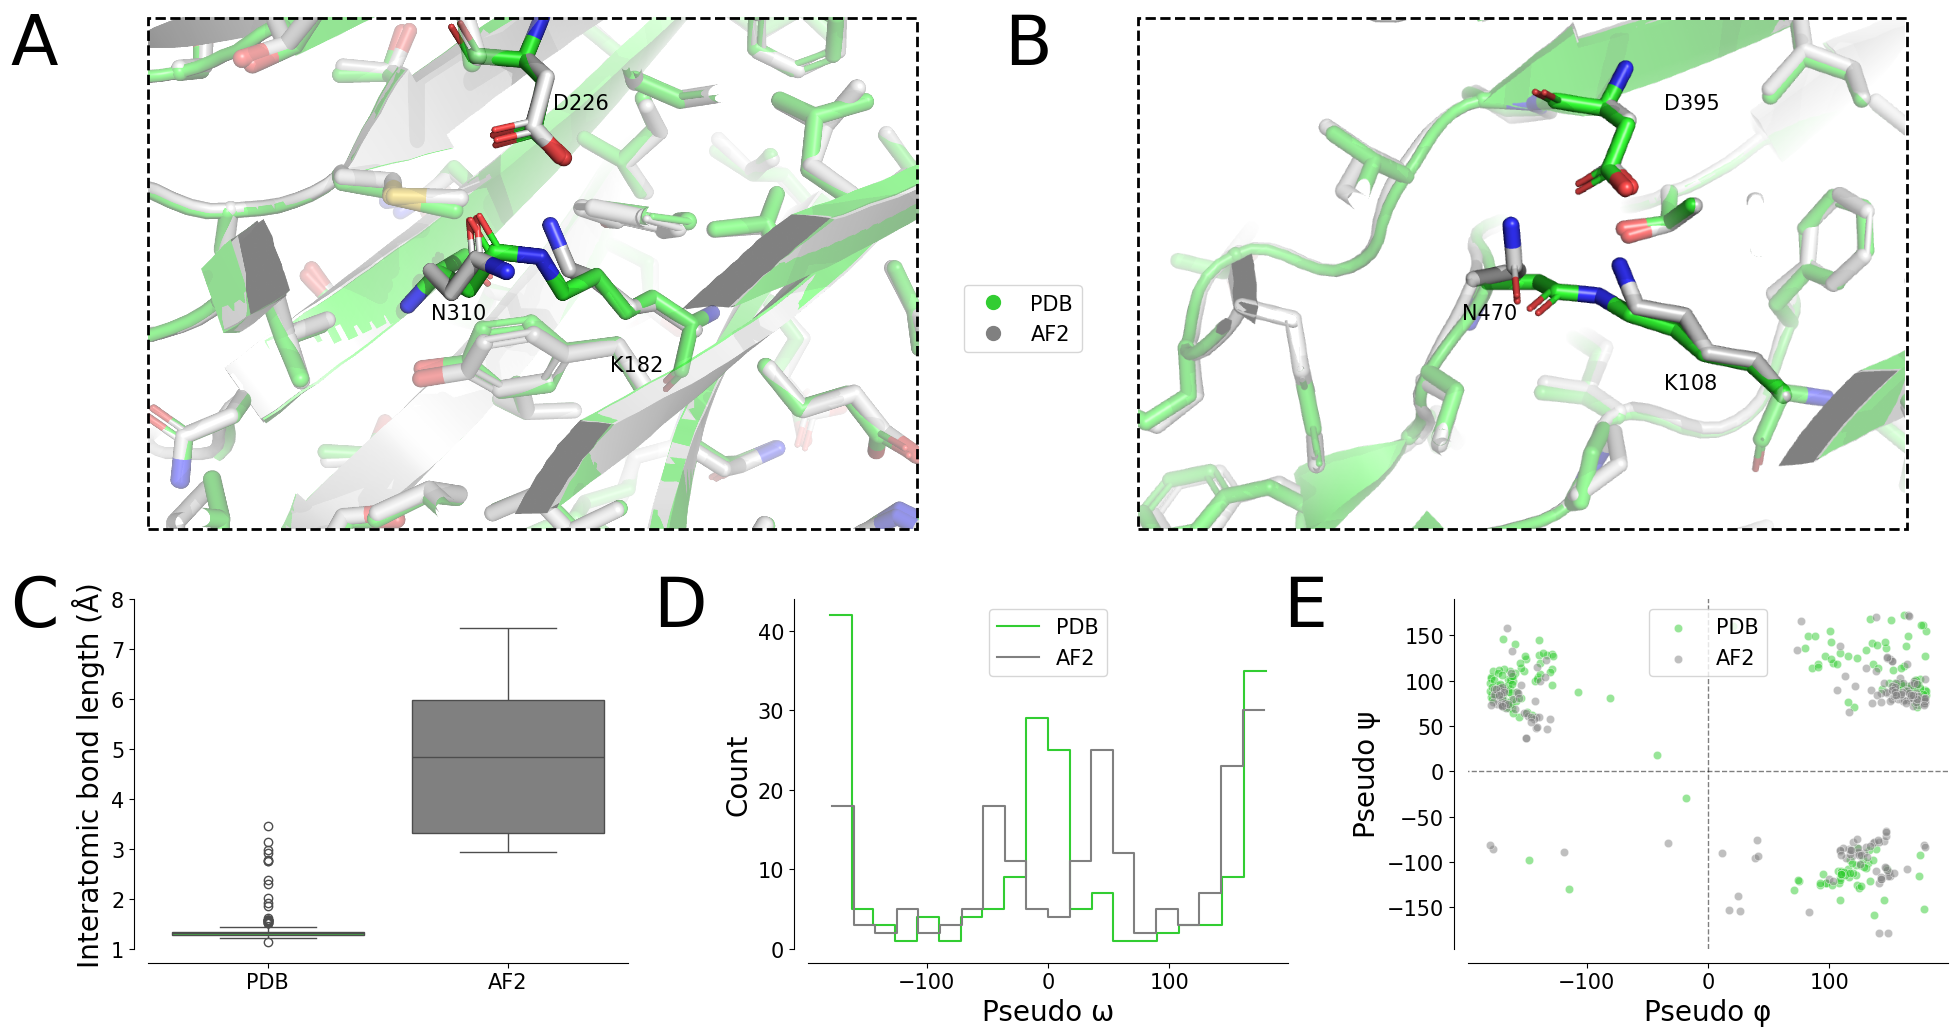

In [13]:
fig = plt.figure(figsize=[20, 10])
gs = gridspec.GridSpec(nrows=2, ncols=6, figure=fig, width_ratios=[1, 1, 1, 1, 1, 1])

# Make plots spanning multiple axes
ax1 = fig.add_subplot(gs[0, :3])
ax2 = fig.add_subplot(gs[0, 3:])
ax3 = fig.add_subplot(gs[1, 0:2])
ax4 = fig.add_subplot(gs[1, 2:4])
ax5 = fig.add_subplot(gs[1, 4:6])

# 1
ax = ax1
ax.axis("off")
# Image of isopep bond
arr_img = plt.imread(os.path.join(INPUT_FIGURES, "5xcb_182_226_310_af_vs_pdb.png"))
cropped_img = arr_img[200:1500, :]
im = OffsetImage(cropped_img, zoom=0.35)
ab = AnnotationBbox(im, xy=(0, 0), xybox=(0, 0), box_alignment=(0, 0), bboxprops=dict(color="white"))
ax.add_artist(ab)

# Box around
box = mpl.patches.Rectangle(
    (0.5 - 1 / 2, 0.5 - 1 / 2),  # Lower-left corner
    .95,
    1.46,
    edgecolor="black",
    linewidth=2,
    linestyle="--",
    facecolor="none", 
    zorder=100,
    clip_on=False
)
ax.add_patch(box)

ax.text(x=.57, y=.45, s="K182")
ax.text(x=.35, y=.6, s="N310")
ax.text(x=.5, y=1.2, s="D226")

# Legend
legend_elements = [
    Line2D([0], [0], marker="o", color="limegreen", lw=0, ms=10, label="PDB"),
    Line2D([0], [0], marker="o", color="gray", lw=0, ms=10, label="AF2"),
]

legend = ax.legend(
    handles=legend_elements,
    loc="center",
    bbox_to_anchor=(1.08, 0.6),
    frameon=True,
)

# 2
ax = ax2
ax.axis("off")
# Image of isopep bond
arr_img = plt.imread(os.path.join(INPUT_FIGURES, "6m3y_108_395_470_af_vs_pdb.png"))
cropped_img = arr_img[150:760, 300:1220]
im = OffsetImage(cropped_img, zoom=0.6)
ab = AnnotationBbox(im, xy=(0, 0), xybox=(0, 0), box_alignment=(0, 0), bboxprops=dict(color="white"))
ax.add_artist(ab)

# Add box around
box = mpl.patches.Rectangle(
    (0.5 - 1 / 2, 0.5 - 1 / 2),  # Lower-left corner
    .95,
    1.46,
    edgecolor="black",
    linewidth=2,
    linestyle="--",
    facecolor="none", 
    zorder=100,
    clip_on=False
)
ax.add_patch(box)

ax.text(x=.65, y=.4, s="K108")
ax.text(x=.4, y=.6, s="N470")
ax.text(x=.65, y=1.2, s="D395")

# 3
ax = ax3
sns.boxplot(x=1, y=dt_df["bond_length"].to_list(), ax=ax, color="limegreen")
sns.boxplot(x=0, y=af_df["bond_length"].to_list(), ax=ax, color="gray")
ax.set_xticks([0,1], ["PDB", "AF2"])
ax.set_ylabel("Interatomic bond length (Å)")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([1,8])
sns.despine(offset=10, ax=ax)

# 4
ax = ax4
sns.histplot(dt_df["pseudo_omega"].to_list(), ax=ax, fill=False, element="step", bins=20, label="PDB", color="limegreen")
sns.histplot(af_df["pseudo_omega"].to_list(), ax=ax,fill=False, element="step", bins=20, label="AF2", color="gray")
ax.legend(loc="upper center")
ax.set_xlabel("Pseudo ω")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.despine(offset=10, ax=ax)

# 5
ax = ax5
sns.scatterplot(dt_df, x="pseudo_phi", y="pseudo_psi", ax=ax, label="PDB", color="limegreen", alpha=.5)
sns.scatterplot(af_df, x="pseudo_phi", y="pseudo_psi", ax=ax, label="AF2", color="gray", alpha=.5)

ax.axvline(0, -181, 181, linewidth=1, color="black", ls="--", alpha=.5)
ax.axhline(0, -181, 181, linewidth=1, color="black", ls="--", alpha=.5)

ax.legend(loc="upper center")
ax.set_xlabel("Pseudo φ")
ax.set_ylabel("Pseudo ψ")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
sns.despine(offset=10, ax=ax)


plt.subplots_adjust(hspace=.2, wspace=1.2, left=0, right=.9)

plt.text(-1400,780, "A", fontsize=ANNOT_FONT_SIZE)
plt.text(-580,780, "B", fontsize=ANNOT_FONT_SIZE)
plt.text(-1400,160, "C", fontsize=ANNOT_FONT_SIZE)
plt.text(-870,160, "D", fontsize=ANNOT_FONT_SIZE)
plt.text(-350,160, "E", fontsize=ANNOT_FONT_SIZE)


plt.savefig(os.path.join(FIGURES, "sf1.png"), dpi=350, bbox_inches="tight", transparent=True)

plt.show()

## Figure S4

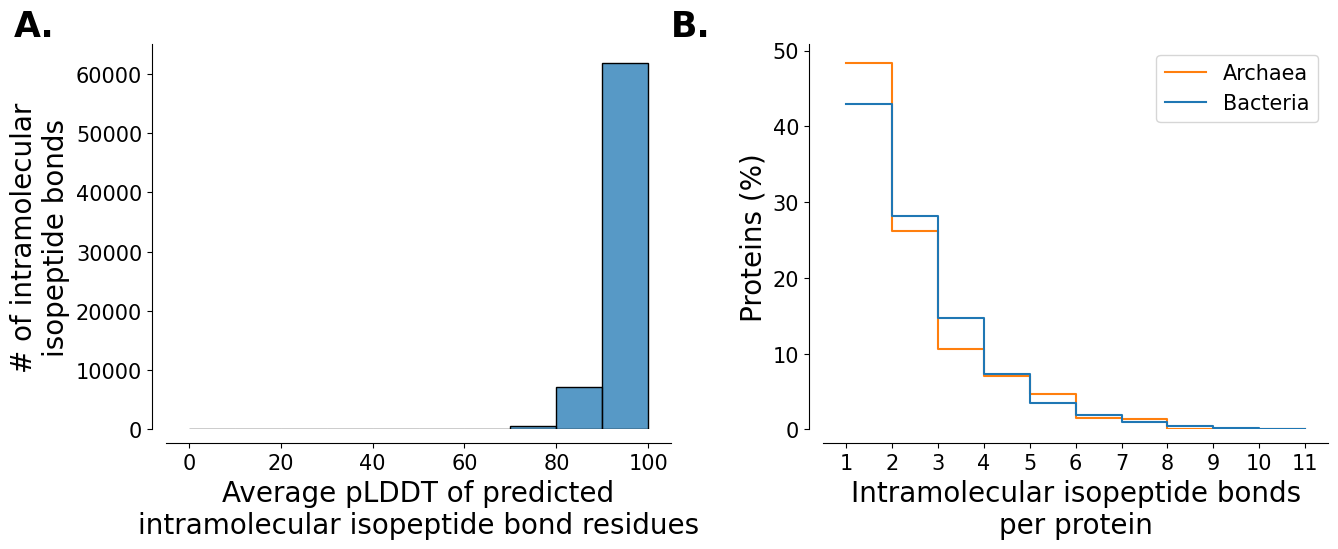

In [17]:
fig, axs = plt.subplots(ncols=2, figsize=[15,5])

# 1
ax=axs[0]
plot_df = str_df[(~str_df["taxonomy"].isna())&(str_df["probability"]>.65)].copy()
plot_df["mean_plddt"] = plot_df.apply(lambda x: np.mean([x["r1_plddt"], x["r2_plddt"], x["r3_plddt"]]), axis=1)
sns.histplot(data=plot_df, x="mean_plddt", bins=10, binrange=[0,100], ax=ax)
sns.despine(offset=10, ax=ax)
ax.set_ylabel("# of intramolecular\nisopeptide bonds")
ax.set_xlabel("Average pLDDT of predicted\nintramolecular isopeptide bond residues")

# 2
ax=axs[1]
plot_df = str_df[(str_df["kingdom"].isin(["Bacteria", "Archaea"]))&(str_df["probability"]>.65)\
    ].value_counts(["kingdom", "uniprot_acc"]).reset_index()

sns.histplot(plot_df, x="count", fill=False, element='step', 
            bins=10, hue="kingdom", common_norm=False, stat="percent", ax=ax)

ax.set_xlabel("Intramolecular isopeptide bonds\nper protein")
ax.set_ylabel("Proteins (%)")
ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11])
sns.despine(offset=10, ax=ax)
ax.legend(title='', labels=["Archaea", "Bacteria"])

#
for i, ax in enumerate(fig.axes, start=1):
    ax.set_title(f"{chr(64+i)}.", loc="left", fontweight='bold', x=-0.3)

plt.subplots_adjust(hspace=3, wspace=0.3)

plt.savefig(os.path.join(FIGURES, "sf4.png"), dpi=350, transparent=True, bbox_inches="tight")

## Figure S3

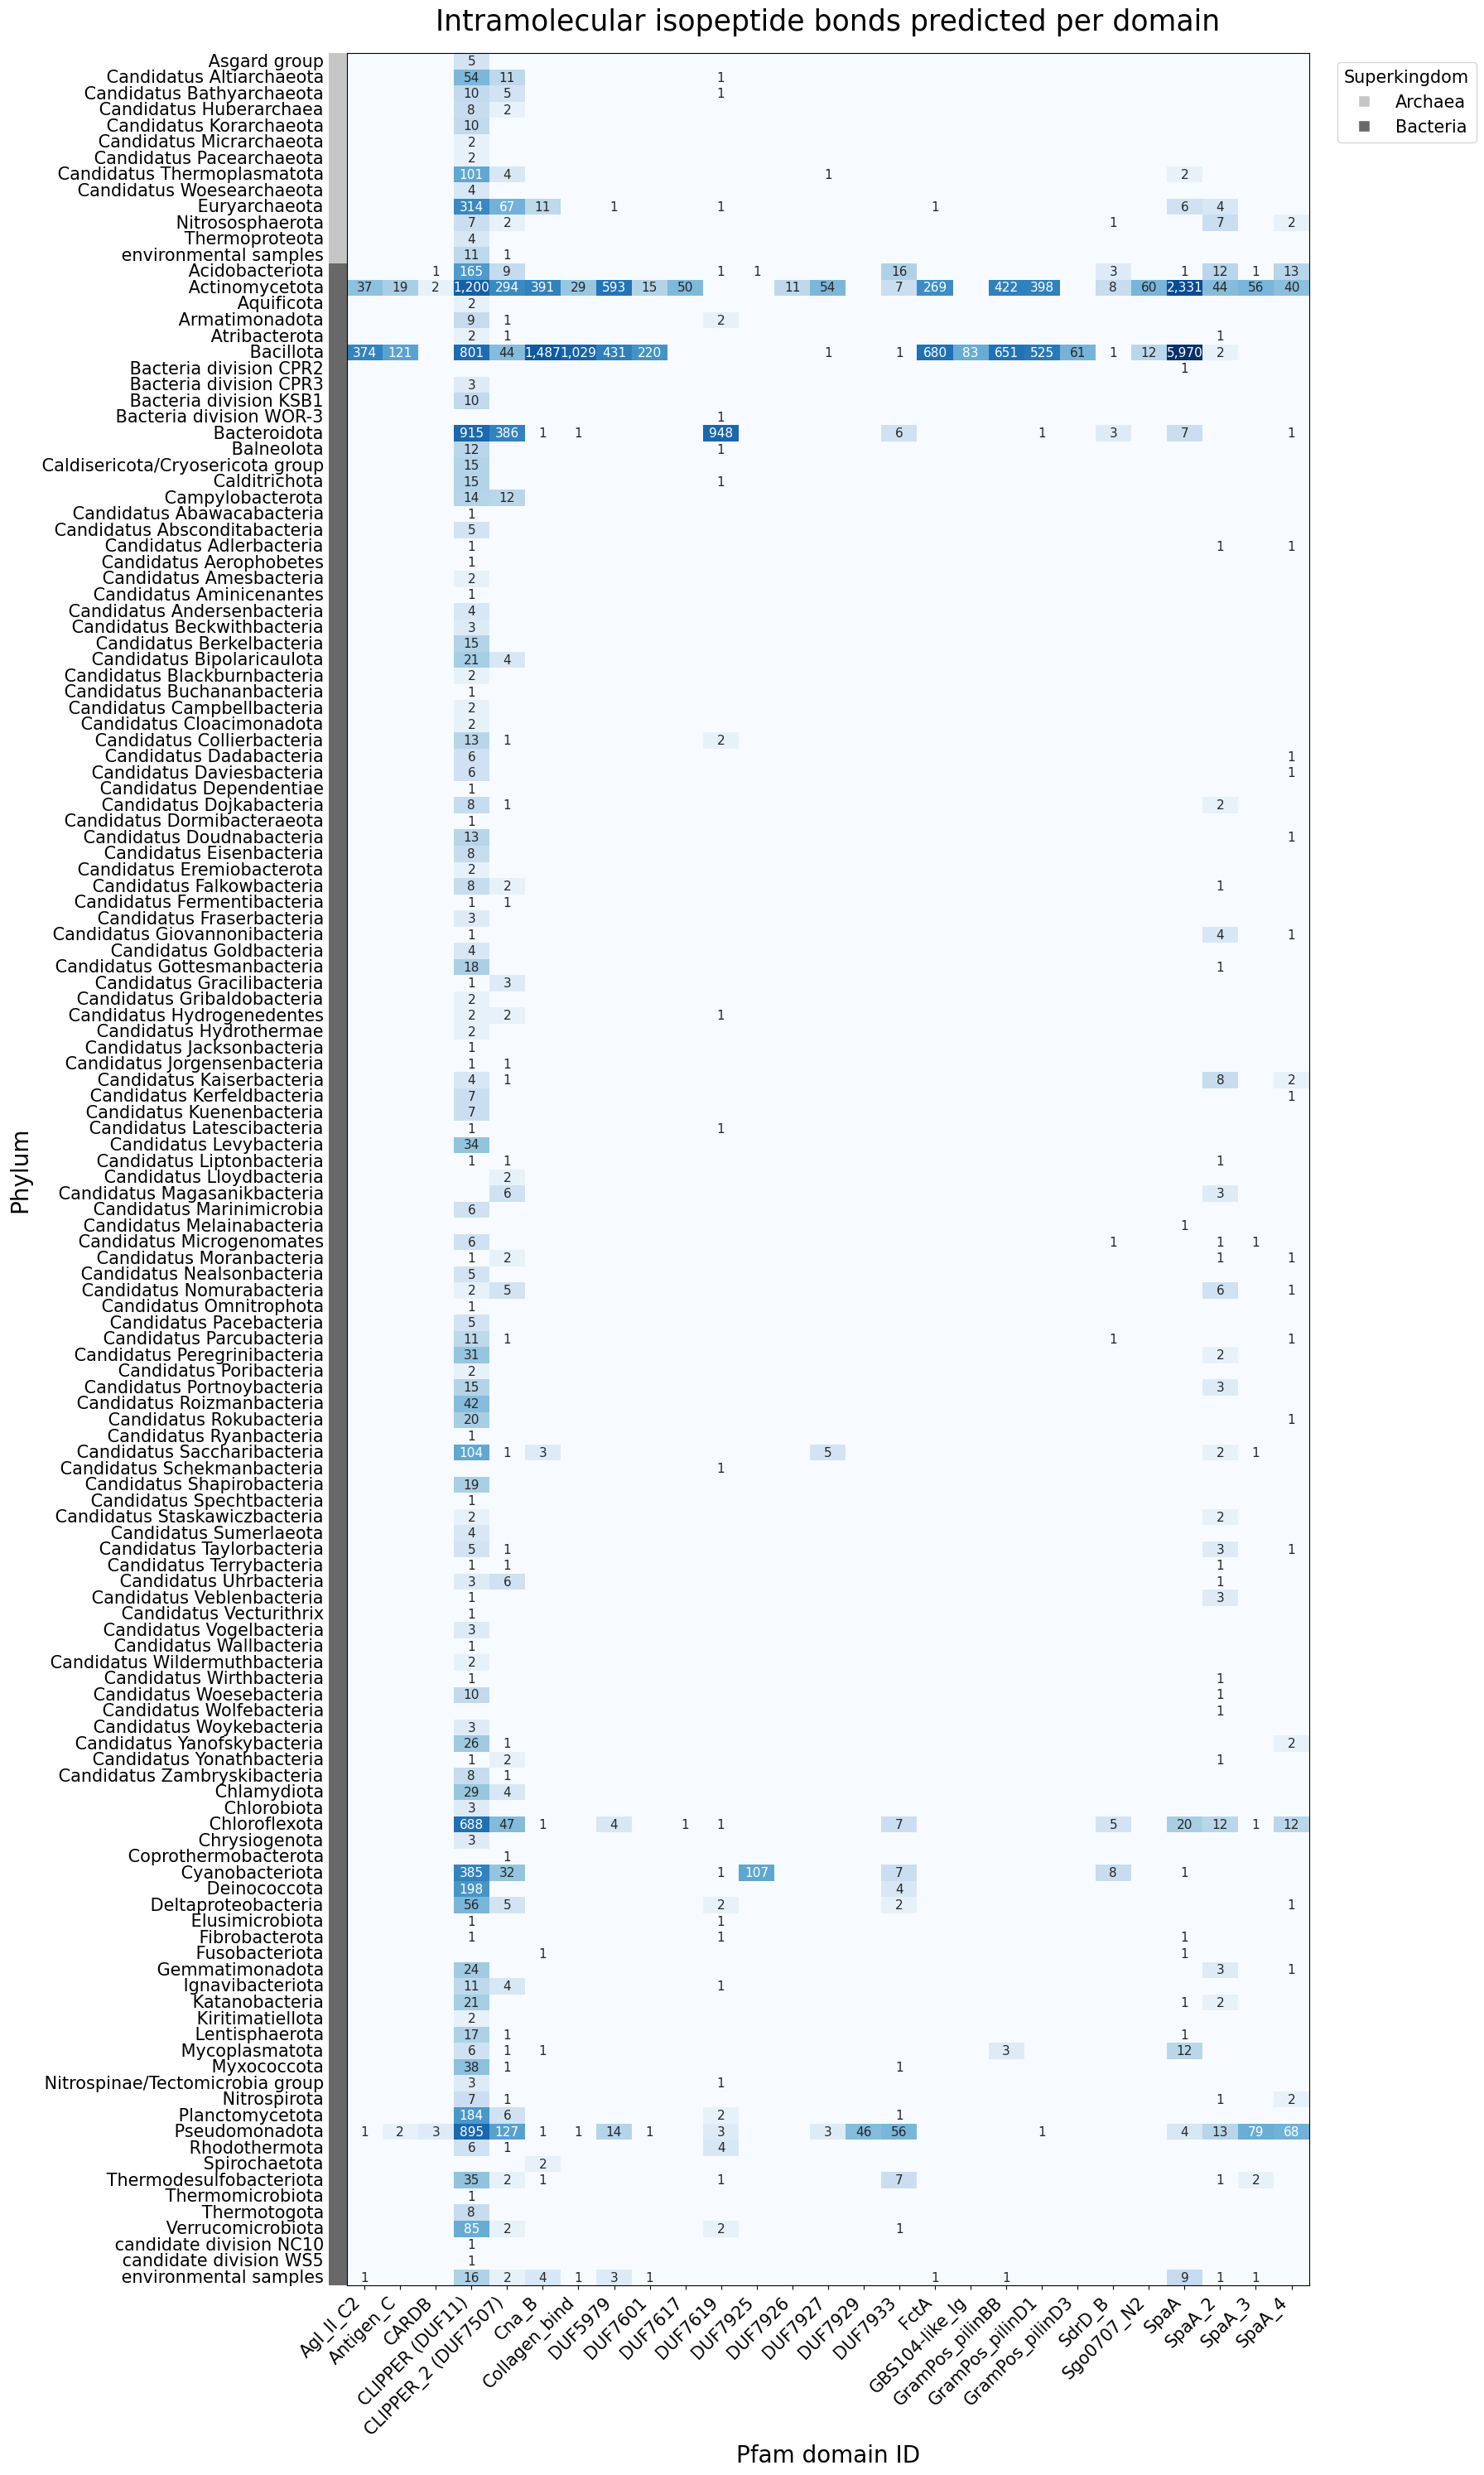

In [19]:
fig, ax = plt.subplots(figsize=[15, 35])

plot_df = str_df[(str_df["probability"]>.65)&(~str_df["taxonomy"].isna())] \
                    .drop_duplicates("uniprot_acc") \
                    .copy()
                    
plot_df["phyla"] = plot_df[(plot_df["kingdom"].isin(["Bacteria", "Archaea"]))] \
                    ["taxonomy"].apply(lambda x: x.split(";")[1].replace(".", "") if len(x.split(";")) >= 2 else np.NaN)

plot_df["pfamA_id"] = plot_df[(plot_df["pfamA_id"].isin(isopep))]["pfamA_id"] \
                        .fillna("Not annotated") \
                        .replace({"DUF11":"CLIPPER (DUF11)", 
                                    "DUF7507":"CLIPPER_2 (DUF7507)"})

plot_df = plot_df.value_counts(["kingdom", "phyla", "pfamA_id"]).reset_index() \
                    .sort_values(["kingdom", "phyla", "count"], ascending=False) \
                    .pivot(index=["kingdom", "phyla"], columns="pfamA_id", values="count") \
                    .fillna(0) \
                    .apply(np.log10)

filled_df = plot_df.replace([np.inf, -np.inf], 0)
g=sns.heatmap(
    filled_df,
    cmap="Blues",
    annot=np.vectorize(lambda x: 10**x)(plot_df),
    fmt=",.0f",
    annot_kws={"fontsize": 11},
    yticklabels=True
)
g.collections[0].colorbar.remove()

# Hide text for 0
for text in ax.texts:
    if text.get_text() == "0":
        text.set_visible(False)

# Add countour lines
for _, spine in ax.spines.items():
    spine.set_visible(True)

# Define color mappings
superkingdoms = plot_df.index.get_level_values(0).unique()
row_lut = dict(zip(superkingdoms, sns.color_palette("Grays", n_colors=len(superkingdoms))))
row_colors = plot_df.index.get_level_values(0).map(row_lut)

# Adjust y-axis tick labels
ax.tick_params(axis='y', which='major', pad=20, length=0)
ax.set_yticklabels(plot_df.index.get_level_values(1), rotation=0)

# Add row color indexing right next to the heatmap
for i, color in enumerate(row_colors):
    ax.add_patch(plt.Rectangle(xy=(-0.5, i), width=0.5, height=1, color=color, lw=0,
                               transform=ax.transData, clip_on=False))

# Legend
row_legend_patches = [plt.Line2D([0], [0], marker='s', color='w', markerfacecolor=row_lut[k], markersize=10, label=k)
                       for k in row_lut.keys()]
ax.legend(handles=row_legend_patches, title="Superkingdom", bbox_to_anchor=(1.02, 1), loc='upper left')

g.set_yticklabels(g.get_yticklabels(), rotation=0)
g.set_xticklabels(g.get_xticklabels(), rotation=45, ha='right')
ax.set_title("Intramolecular isopeptide bonds predicted per domain", pad=20)
ax.set_ylabel("Phylum")
ax.set_xlabel("Pfam domain ID")

plt.savefig(os.path.join(FIGURES, "sf3.png"), dpi=350, bbox_inches="tight", pad_inches=0)

## Figure S2

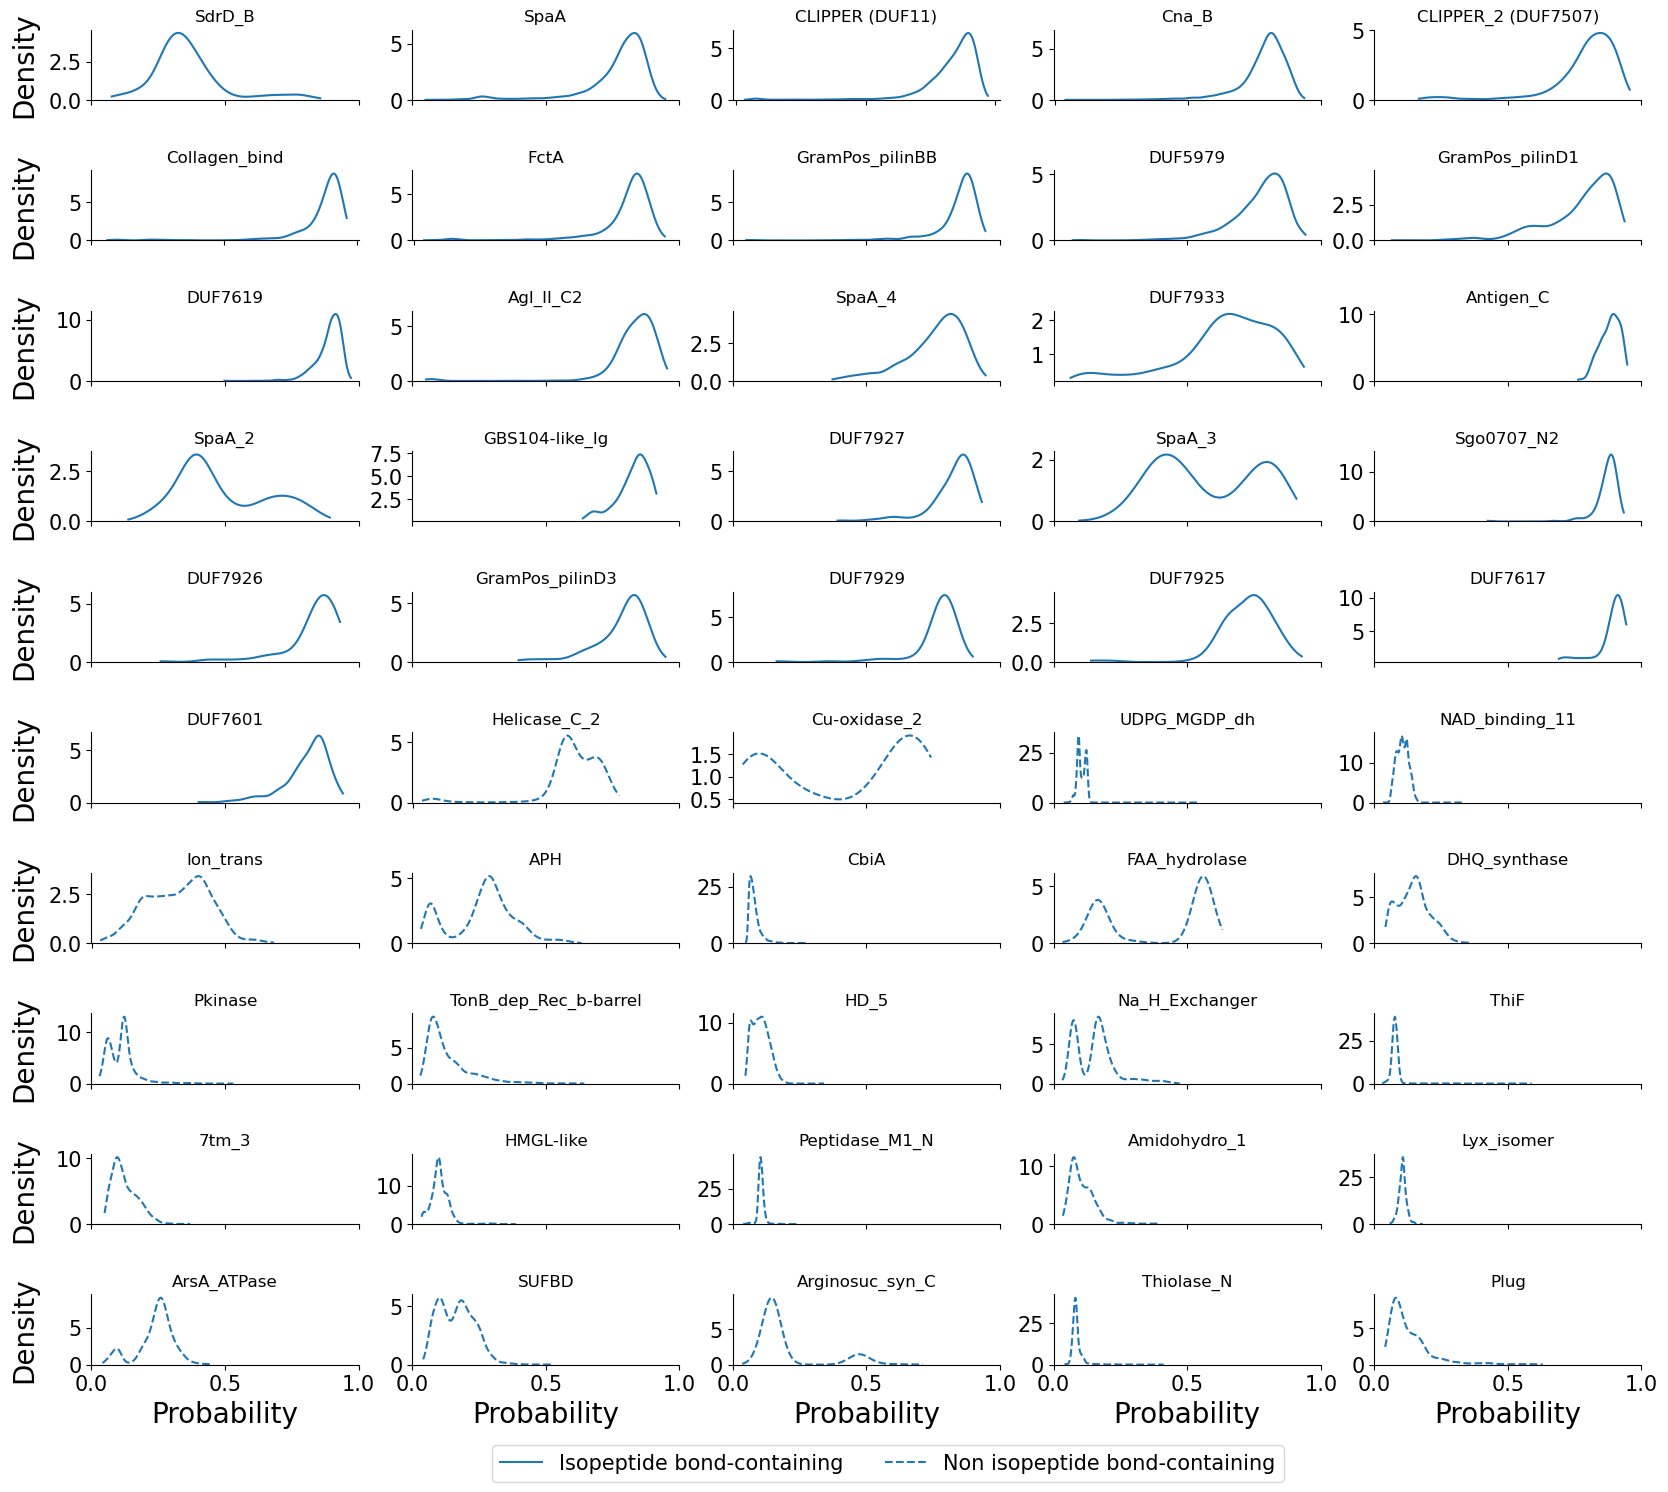

In [14]:
# Keep only the match with lower rmsd per domain

nrows=10
ncols=5

fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=[20,15])
plt.subplots_adjust(left=None, bottom=None, right=None, top=1, wspace=None, hspace=1)

axes = [[row, col] for row in range(nrows) for col in range(ncols)]
for indx, pfamA_id in zip(axes, isopep + ["Helicase_C_2", "Cu-oxidase_2"] + str_df[~str_df["pfamA_id"]\
                          .isin(isopep)].value_counts("pfamA_id").reset_index()["pfamA_id"][:48-len(isopep)].to_list()):
    ax = axs[indx[0], indx[1]]
    if pfamA_id not in isopep:
        sns.kdeplot(str_df[str_df["pfamA_id"]==pfamA_id],
                    x="probability", cut=0, ax=ax, ls="--")
    else:
        sns.kdeplot(str_df[str_df["pfamA_id"]==pfamA_id],
                    x="probability", cut=0, ax=ax)
    if pfamA_id == "DUF11":
        pfamA_id = "CLIPPER (DUF11)"
    if pfamA_id == "DUF7507":
        pfamA_id = "CLIPPER_2 (DUF7507)"
    ax.set_title(pfamA_id, fontsize=12)
    ax.set_xlabel("Probability")
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if indx[0] == nrows - 1:
        ax.set_xticks([0, .5, 1])
        ax.set_xlabel("Probability")
    else:
       ax.set(xticks=[0, .5, 1], xlabel="")
       plt.setp(ax.get_xticklabels(), visible=False)

    if indx[1] == 0:
        ax.set_ylabel("Density")
        ax.yaxis.set_label_coords(-0.2, 0.5)
    else:
        ax.set_ylabel("")
    
ibd_line, = plt.plot([], [], linestyle='-', color='C0', label='Isopeptide bond-containing')
non_ibd_line, = plt.plot([], [], linestyle='--', color='C0', label='Non isopeptide bond-containing')
plt.legend(handles=[ibd_line, non_ibd_line], ncol=2, bbox_to_anchor=(-.3,-1))

# IDK why but this is needed
ax.set(xticks=[0, .5, 1])

plt.savefig(os.path.join(FIGURES, "sf2.png"), dpi=350, bbox_inches="tight", pad_inches=0)